<a href="https://colab.research.google.com/github/lilfetz22/Running_data/blob/master/Running_Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Running Log Analysis**

###Goals


By 9/17 - complete pre-Garmin Data Wrangling
1. check for any remaining information in Notes columns - done (9/17)
2. Fix Date column and fill it in and make it agree with weekday (10/1)
3. remove excess columns (10/5)

By 10/1 - Complete post-Garmin analysis
1. Data Wrangling

    a. filtering out activities from one another - done

    b. comparing overlap from pre-garmin to post-Garmin records and fill in missing data - done

In [3]:
import pandas as pd
import re
import numpy as np
import math
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from time import time
from scipy import stats
from functools import reduce


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Garmin Data Wrangling

In [5]:
def findall_n_join_fx(df, note_col, new_col, search_string):
    df.loc[:,new_col] = df.loc[:,note_col].str.findall(search_string)
    df.loc[:,new_col] = df.loc[:,new_col].str.join('')
    df.loc[:,note_col] = df.loc[:,note_col].str.replace(search_string, '')
    return df

In [6]:
log_csv = pd.read_csv("/content/drive/My Drive/pre-garmin.csv",encoding='windows-1254')
log_csv.head(15)

,Running log 6/21/10,3/17/14,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Saturday 5/29/10,NaN,4 miles 27:19 it was a little short. 3.8 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monday 6/21/10,4 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tuesday 6/22/10,4 miles,Swimming,10 laps of freestyle,5 laps of backstroke,5,laps of breaststroke,NaN,1 lap all out of freestyle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wednesday 6/23/10,4.5 miles,35 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thursday 6/25/10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Friday 6/26/10,5,Swimming,same as Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Saturday 6/27/10,6,41:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Monday 6/28/10,4,28:04:00,5 total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tuesday 6/29/10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
log_csv.tail()

,Running log 6/21/10,3/17/14,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
1979,TOTAL - 48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,Monday - 12/21/15 - off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,Tuesday - I've failed. Not going to be able to...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,Thursday - 12/25/15 - 3 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,Thursday - 12/31/15 - 30 minutes biking - 9.5 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creation of Raw string before manipulation of columns

In [8]:
log_csv.columns

Index(['Running log 6/21/10 ', ' 3/17/14', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')

In [9]:
raw_string = log_csv.copy()
raw_string['raw_note'] = raw_string['Running log 6/21/10 '].str.cat(raw_string[[' 3/17/14','Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7',
                                                     'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11','Unnamed: 12',
                                                     'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Unnamed: 17']].astype(str), sep="_")
raw_string2 = raw_string[['raw_note']]
raw_string2.loc[:, 'raw_note'] = raw_string2.loc[:, 'raw_note'].str.replace('_?nan_?', '')
raw_string2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,raw_note
0,Saturday 5/29/10 4 miles 27:19 it was a little...
1,Monday 6/21/10_ 4 miles
2,Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...
3,Wednesday 6/23/10_ 4.5 miles_35 minutes
4,Thursday 6/25/10_ 5


In [10]:
log_csv['Notes'] = log_csv['Unnamed: 2'].str.cat(log_csv[['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7',
                                                     'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11','Unnamed: 12',
                                                     'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Unnamed: 17']].astype(str), sep="_")
log_csv2 = log_csv[['Running log 6/21/10 ',' 3/17/14','Notes']]
log_csv2.head(10)

,Running log 6/21/10,3/17/14,Notes
0,Saturday 5/29/10,NaN,4 miles 27:19 it was a little short. 3.8 mile...
1,Monday 6/21/10,4 miles,NaN
2,Tuesday 6/22/10,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...
3,Wednesday 6/23/10,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...
4,Thursday 6/25/10,5,NaN
5,Friday 6/26/10,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...
6,Saturday 6/27/10,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...
7,NaN,NaN,NaN
8,Monday 6/28/10,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...
9,Tuesday 6/29/10,5,NaN


In [11]:
# columns = ['Weekday', 'Date', 'Mileage', 'Minutes', 'Notes']
log_csv2.columns = ['Beginning', 'Mileage', 'Notes']

In [12]:
m = '- 7 miles - warmup with maggie - 82.190 - 6:19:16 - 13.0 avg'
t = '- 8 miles - thanksgiving 18.229 mile'
e = '35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan'
re.sub('_nan', '', e)

'35 minutes'

In [13]:
findall_n_join_fx(log_csv2, 'Beginning', 'Weekday', '\w+day')
log_csv2 = findall_n_join_fx(log_csv2, 'Beginning', 'Date', '\d+/\d+/\d\d')
log_csv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Beginning  1966 non-null   object
 1   Mileage    1217 non-null   object
 2   Notes      751 non-null    object
 3   Weekday    1966 non-null   object
 4   Date       1966 non-null   object
dtypes: object(5)
memory usage: 77.6+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [14]:
log_csv3 = log_csv2[log_csv2['Beginning'].str.startswith('TOTAL') == False]

In [15]:
log_csv3.loc[:,'Mileage_init'] = log_csv3.loc[:,'Beginning'].str.findall('\d+\.*\d*')
log_csv3.loc[:, 'length'] = log_csv3['Mileage_init'].str.len()
log_csv3['counter'] = range(len(log_csv3))
log_csv3['Workout_mins'] = np.nan
log_csv3['Swimming_meters'] = np.nan
log_csv3['Bike_Mileage'] = np.nan
log_csv3 = log_csv3.rename(columns = {'Beginning': 'Notes2'})
check_data = log_csv3[log_csv3.length >1]
check_data2 = check_data[['Notes2','Mileage','Mileage_init','counter']]
len(check_data2)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

157

#### Manipulations

In [16]:
log_csv3.iloc[1138,5] = np.nan
log_csv3.iloc[1206,5] = np.nan
log_csv3.iloc[1431,5] = np.nan
log_csv3.iloc[1432,5] = np.nan
log_csv3.iloc[1527,5] = np.nan
log_csv3.iloc[1561,5] = np.nan
log_csv3.iloc[1596,5] = np.nan
log_csv3.iloc[1614,5] = np.nan
log_csv3.iloc[1632,5] = np.nan
log_csv3.iloc[1648,5] = np.nan
log_csv3.iloc[1316,5] = np.nan

#### New Log

In [17]:
log_csv3.to_csv("/content/drive/My Drive/mileage_manip2.csv")

In [18]:
new_log = pd.read_csv("/content/drive/My Drive/mileage_manip2.csv",index_col=0)
new_log.head(10)

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,[],0,0,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,[],0,1,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,[],0,2,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,[],0,3,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,[],0,4,NaN,NaN,NaN
5,,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...,Friday,6/26/10,[],0,5,NaN,NaN,NaN
6,,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Saturday,6/27/10,[],0,6,NaN,NaN,NaN
8,,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...,Monday,6/28/10,[],0,7,NaN,NaN,NaN
9,,5,NaN,Tuesday,6/29/10,[],0,8,NaN,NaN,NaN
10,,5.5,Swimming_normal_nan_nan_nan_nan_nan_nan_nan_na...,Wednesday,6/30/10,[],0,9,NaN,NaN,NaN


In [19]:
new_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1723 entries, 0 to 1983
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1665 non-null   object 
 1   Mileage          1068 non-null   object 
 2   Notes            741 non-null    object 
 3   Weekday          1618 non-null   object 
 4   Date             139 non-null    object 
 5   Mileage_init     1712 non-null   object 
 6   length           1723 non-null   int64  
 7   counter          1723 non-null   int64  
 8   Workout_mins     0 non-null      float64
 9   Swimming_meters  0 non-null      float64
 10  Bike_Mileage     0 non-null      float64
dtypes: float64(3), int64(2), object(6)
memory usage: 161.5+ KB


In [20]:
to_be_nan = list(new_log.counter[new_log.length > 1])
for row_numb in to_be_nan:
    new_log.iloc[row_numb,5] = np.nan

In [21]:
# mi = list(new_log.Mileage_init)
# for idx, a in enumerate(mi):
#     try:
#         if math.isnan(a):
#             continue
#     except:
#         if len(a) < 1:
#             continue
#         else:
#             new_log.Mileage_init.iloc[idx] = a[0]

In [22]:
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\[\'', '')
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\'\]', '')
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\[\]', '')

In [23]:
new_log.Mileage_init = pd.to_numeric(new_log.Mileage_init, errors='coerce')
new_log.head()

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,NaN,0,1,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,NaN,0,4,NaN,NaN,NaN


In [24]:
new_log.insert(8, 'Workout_type',None)

In [25]:
new_log.head()

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN


In [26]:
# dropping two lines that just had "WORKOUTS TOTAL"
new_log = new_log.drop([30,143,187,334,360,442,610,789,969,1113,1121,1131,1258,1259,1260,
                        1261,1262,1453,1523,1598,1643,1652,1686,1727,1737,1747,1756,1757,
                        1767,1776,1777,1786,1787,1796,1797,1807,1816,1825,1834,1843,1852,
                        1861,1870,1879,1895,1904,1913,1922,1931])
new_log['counter'] = range(len(new_log))

In [27]:
def workout_finder_fx(df, col, str_search, minutes, workout_type, *exclude):
    w_o = list(df.loc[:, col].str.contains(str_search))
    for idx, n in enumerate(w_o):
        if n == None:
            continue
        elif n == True:
            enough_to_exclude = 0
            for e in exclude:
                o2 = re.search(e, df[col].iloc[idx])
                if o2:
                    enough_to_exclude += 1
            if enough_to_exclude < 1:
                df['Workout_type'].iloc[idx] = workout_type
                df['Workout_mins'].iloc[idx] = minutes
    return df



In [28]:
ab_workout_incl_log = workout_finder_fx(new_log, 'Notes2', '[Aa]b [Ww]orkout', 20, 'abs')
gym_workout_incl_log = workout_finder_fx(ab_workout_incl_log, 'Notes2', '[Ww]orkout',45, 'gym', '[Ss]wim', '[Aa]b')
print(gym_workout_incl_log.iloc[1084])
gym_workout_incl_log.iloc[1267]

Notes2              - mile warmup - 4.5 miles - dads loop - 3 mil...
Mileage                                                          NaN
Notes                                                            NaN
Weekday                                                     Saturday
Date                                                             NaN
Mileage_init                                                     NaN
length                                                             9
counter                                                         1084
Workout_type                                                    None
Workout_mins                                                     NaN
Swimming_meters                                                  NaN
Bike_Mileage                                                     NaN
Name: 1283, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Notes2              - workout between classes
Mileage                                   NaN
Notes                                     NaN
Weekday                              Thursday
Date                                      NaN
Mileage_init                              NaN
length                                      0
counter                                  1267
Workout_type                              gym
Workout_mins                               45
Swimming_meters                           NaN
Bike_Mileage                              NaN
Name: 1492, dtype: object

Mileage Column

In [29]:
gym_workout_incl_log.iloc[314]

Notes2                                              
Mileage             6 miles greystone then dads loop
Notes                                            NaN
Weekday                                     Saturday
Date                                             NaN
Mileage_init                                     NaN
length                                             0
counter                                          314
Workout_type                                    None
Workout_mins                                     NaN
Swimming_meters                                  NaN
Bike_Mileage                                     NaN
Name: 376, dtype: object

In [30]:
# might need to try out the "try" in a function to see if it can be converted to 
# an integer if not, then put the note into a separate column and delete it from
# the mileage column
def remove_mileage_notes_fx(df, col):
    notes3_col = [''] * len(df[col])
    list_col = list(df.loc[:, col])
    for idx, a in enumerate(list_col):
        try:
            float_a = float(a)
            df[col].iloc[idx] = float_a
        except:
            notes3_col[idx] = a
            df[col].iloc[idx] = np.nan
    df['Notes3'] = notes3_col
    return df
sep_notes_from_mileage_col = remove_mileage_notes_fx(gym_workout_incl_log, 'Mileage')
sep_notes_from_mileage_col.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,
1,,NaN,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,4 miles
2,,NaN,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN,4 miles
3,,NaN,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,4.5 miles
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,
5,,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...,Friday,6/26/10,NaN,0,5,None,NaN,NaN,NaN,
6,,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Saturday,6/27/10,NaN,0,6,None,NaN,NaN,NaN,
8,,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...,Monday,6/28/10,NaN,0,7,None,NaN,NaN,NaN,
9,,5,NaN,Tuesday,6/29/10,NaN,0,8,None,NaN,NaN,NaN,
10,,5.5,Swimming_normal_nan_nan_nan_nan_nan_nan_nan_na...,Wednesday,6/30/10,NaN,0,9,None,NaN,NaN,NaN,


took all of the text that was in the mileage column and moved it to a separate column, and left any number that was purely a number and converted the column to be integers. 

In [31]:
# now I need to go through the notes3 column and pull out any that have just mileage, 
#then I will need to go through and search those that have dates and other mess 
#in there, then I will need to apply the same functions to the Notes column

In [32]:
findall_n_join_fx(sep_notes_from_mileage_col, 'Notes3', 'Date2', '\d+/\d+/\d\d')

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,,
1,,NaN,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,4 miles,
2,,NaN,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN,4 miles,
3,,NaN,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,4.5 miles,
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,- 10 miles,NaN,NaN,Sunday,NaN,10.0,1,1669,None,NaN,NaN,NaN,,
1980,- - off,NaN,NaN,Monday,12/21/15,NaN,0,1670,None,NaN,NaN,NaN,,
1981,- I've failed. Not going to be able to run fo...,NaN,NaN,Tuesday,NaN,NaN,0,1671,None,NaN,NaN,NaN,,
1982,- - 3 miles,NaN,NaN,Thursday,12/25/15,3.0,1,1672,None,NaN,NaN,NaN,,


In [33]:
sep_notes_from_mileage_col.Date.loc[34]

'7/28/10'

In [34]:
def date_finder_fx(df, new_date):
    date_col = list(df[new_date])
    for idx, date in enumerate(date_col):
        try:
            if math.isnan(date):
                continue
        except:
            if date == '':
                continue
            try:
                if math.isnan(df['Date'].iloc[idx]):
                    df['Date'].iloc[idx] = date
            except:
                continue
                

In [35]:
date_finder_fx(sep_notes_from_mileage_col, 'Date2')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [36]:
sep_notes_from_mileage_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     68 non-null     object 
 9   Workout_mins     68 non-null     float64
 10  Swimming_meters  0 non-null      float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 276.2+ KB


In [37]:
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('_nan', '')

In [38]:
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.lower()
sep_notes_from_mileage_col.loc[:, 'Notes2'] = sep_notes_from_mileage_col.loc[:, 'Notes2'].str.lower()
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.lower()

In [39]:
sep_notes_from_mileage_col['Mileage_init2'] = sep_notes_from_mileage_col.Notes3.str.findall('\d+\.?\d* miles?')
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.replace('\d+\.?\d* miles?', '')
sep_notes_from_mileage_col['Mileage_init3'] = sep_notes_from_mileage_col.Notes.str.findall('\d+\.?\d* miles?')
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('\d+\.?\d* miles?', '')
sep_notes_from_mileage_col['Mileage_init4'] = sep_notes_from_mileage_col.Notes3.str.findall('\d+\.?\d* total')
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.replace('\d+\.?\d* total', '')
sep_notes_from_mileage_col['Mileage_init5'] = sep_notes_from_mileage_col.Notes.str.findall('\d+\.?\d* total')
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('\d+\.?\d* total', '')

In [40]:
gym_workout_incl_log2 = workout_finder_fx(sep_notes_from_mileage_col, 'Notes', 'workout', 45, 'gym', 'swim', 'ab','pool')
gym_workout_incl_log2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     73 non-null     object 
 9   Workout_mins     73 non-null     float64
 10  Swimming_meters  0 non-null      float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
 14  Mileage_init2    1674 non-null   object 
 15  Mileage_init3    740 non-null    object 
 16  Mileage_init4    1674 non-null   object 
 17  Mileage_init5 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [41]:
def swim_workout_fx(df, col, str_search): 
    for s in str_search:
        w_o2 = list(df.loc[:, col].str.contains(s))
        for idx, w in enumerate(w_o2):
            if w == None:
                continue
            elif w == True:
                df['Swimming_meters'].iloc[idx] = 1600

In [42]:
swim_workout_fx(gym_workout_incl_log2, 'Notes', ['swim','pool'])
swim_workout_fx(gym_workout_incl_log2, 'Notes2', ['swim','pool'])
swim_workout_fx(gym_workout_incl_log2, 'Notes3', ['swim','pool'])
gym_workout_incl_log2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     73 non-null     object 
 9   Workout_mins     73 non-null     float64
 10  Swimming_meters  39 non-null     float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
 14  Mileage_init2    1674 non-null   object 
 15  Mileage_init3    740 non-null    object 
 16  Mileage_init4    1674 non-null   object 
 17  Mileage_init5 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [43]:
def mileage_finder_fx(df, init, total_or_miles):
    multiple_miles = []
    too_big = []
    already_in_col = []
    for idx, row in enumerate(df.loc[:, init]):
        try:
            if math.isnan(row):
                continue
        except:
            if len(row) > 1:
                multiple_miles.append(idx)
            elif len(row) == 1:
                mile_str = row[0].replace(total_or_miles, '')
                try:
                    mile_float = float(mile_str)
                    if math.isnan(df['Mileage'].iloc[idx]):
                        if mile_float > 27.2:
                            too_big.append(idx)
                        else:
                            df['Mileage'].iloc[idx] = mile_float
                    else:
                        already_in_col.append(idx)
                except:
                    continue
    return multiple_miles, too_big, already_in_col



In [44]:
mm3, tb3, aic3 = mileage_finder_fx(gym_workout_incl_log2,'Mileage_init4','total')
print(len(mm3),len(tb3),len(aic3))
mm4, tb4, aic4 = mileage_finder_fx(gym_workout_incl_log2, 'Mileage_init5', 'total')
print(len(mm4),len(tb4),len(aic4))
mm, tb, aic = mileage_finder_fx(gym_workout_incl_log2,'Mileage_init2','miles')
print(len(mm),len(tb),len(aic))
mm2, tb2, aic2 = mileage_finder_fx(gym_workout_incl_log2, 'Mileage_init3', 'miles')
print(len(mm2),len(tb2),len(aic2))

0 0 0
1 0 3


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


5 3 36
67 0 89


For each of the following I will be manually putting in the data to fix the issue since they are outliers in being able to conform nicely to a computer function. 

In [45]:
comb = mm4 + aic4 + mm + tb + aic + mm2 + aic2
comb_array = np.array(comb)
comb_uni = np.unique(comb_array)

In [46]:
time_added = gym_workout_incl_log2.copy()
time_added.insert(2, 'Time', None)

In [47]:
raw_string_added = pd.merge(time_added, raw_string2, how='left',left_index=True, right_index=True)

In [48]:
def manual_input_desc(df, list_name):
    for ind in list_name:
        print(df[['Mileage','Bike_Mileage', 'Time','Weekday', 'Date','Workout_type', 'Workout_mins', 'Swimming_meters']].iloc[ind])
        print('RAW: ', df['raw_note'].iloc[ind])

In [49]:
#manual_input_desc(raw_string_added, mm4)

In [50]:
#manual_input_desc(raw_string_added, aic4)

In [51]:
#manual_input_desc(raw_string_added, mm)

In [52]:
#manual_input_desc(raw_string_added, tb)

In [53]:
#manual_input_desc(raw_string_added, aic)

In [54]:
#manual_input_desc(raw_string_added, mm2)

In [55]:
#manual_input_desc(raw_string_added, aic2)

In [56]:
mil = list(raw_string_added.Mileage_init)
multi = []
for idx, m in enumerate(mil):
    if math.isnan(m):
        continue
    elif math.isnan(raw_string_added['Mileage'].iloc[idx]):
        raw_string_added['Mileage'].iloc[idx] = m
    else:
        multi.append(idx)
len(multi)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0

Search for more data inside of the Notes columns

In [57]:
raw_string_added['Notes'] = raw_string_added['Notes'].replace(np.nan, '')
raw_string_added['Notes2'] = raw_string_added['Notes2'].replace(np.nan, '')

In [58]:
raw_string_added['Notes_comb'] = raw_string_added['Notes'].str.cat(raw_string_added[['Notes2','Notes3']].astype(str), sep="_")
raw_string_added.head()

,Notes2,Mileage,Time,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2,Mileage_init2,Mileage_init3,Mileage_init4,Mileage_init5,raw_note,Notes_comb
0,,NaN,None,27:19 it was a little short.,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,,,[],"[4 miles, 3.8 miles]",[],[],Saturday 5/29/10 4 miles 27:19 it was a little...,27:19 it was a little short. _ _
1,,4,None,,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,,,[4 miles],NaN,[],NaN,Monday 6/21/10_ 4 miles,_ _
2,,4,None,swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,1600.0,NaN,,,[4 miles],[],[],[],Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...,swimming_ 10 laps of freestyle_5 laps of backs...
3,,4.5,None,35 minutes,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,,,[4.5 miles],[],[],[],Wednesday 6/23/10_ 4.5 miles_35 minutes,35 minutes_ _
4,,5,None,,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Thursday 6/25/10_ 5,_ _


In [59]:
raw_string_added['numbers'] = raw_string_added.Notes_comb.str.findall('\d+\.*\d*')

In [60]:
greater_2 = []
two = []
one = []
for idx, num in enumerate(raw_string_added.numbers):
    if (len(num) > 2) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        greater_2.append(idx)
    elif (len(num) == 2) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        two.append(idx)
    elif (len(num) == 1) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        one.append(idx)
print(len(greater_2), len(two), len(one))



129 78 59


In [61]:
#manual_input_desc(raw_string_added, greater_2)

In [62]:
#manual_input_desc(raw_string_added, two)

In [63]:
#manual_input_desc(raw_string_added, one)

need to look at every row that is null for mileage and see whether it should be null or not

In [64]:
l_comb_uni = list(comb_uni)

In [65]:
comb_2 = l_comb_uni + greater_2 + two + one

In [66]:
missing_mileage = []
for idx, w in enumerate(raw_string_added['Mileage']):
    if (math.isnan(w)) and (idx not in comb_2):
        missing_mileage.append(idx)

In [67]:
manual_changes = {'Mileage': [[339,6.5],[8,5],[729,13],[23,6.5],[34,2],[53,8],[1247,21],[0,3.8],[43,6.5],[223,9],[373,5],[383,9],[514,9],[534,7],[542,13],[547,9],[551,7],[591,9],[756,9],[832,6],[901,10],
                          [903,8],[908,10.5],[910,8.19],[924,11.5],[1074,8],[1099,9],[1102,13.1],[1107,8],[1108,11.3],[1114,11],[1122,7],[1247,21],[1255,26.2],[11,6],[16,5],[22,7],[32,9.25],[39,4],
                          [55,6],[64,4],[88,5],[164,8],[20, 8],[50,4],[100,4.2],[102,8],[125,4.2],[181,8.5],[186, 12],[218,4],[222,8],[241,4],[252,5.5],[264,7],[304,10],[316,10.5],[337,8],[358,11],
                          [359,8],[371,8],[394,4.2],[412,7.5],[419,5.5],[426,4],[428,6],[447,3],[493,9.5],[541,10.5],[543,5.5],[544,5],[560,9.5],[572,4.5],[582,9],[601,9.5],[670,6],[699,5.5],[714,11],
                          [28,5.5],[181,8.5],[206,6],[303,2.5],[382,4],[483,10.5],[484,10.5],[486,13],[491,16],[498,16],[511,11.5],[537,7.5],[584,11],[587,9],[632,9.5],[642,4],[665,7.5],[25,4],[31,3.5],
                          [137,6.5],[139,3],[202,2],[219,7.5],[285,6],[287,2.5],[289,5],[302,2.5],[326,3],[327,4.5],[332,1.5],[374,4.5],[379,4],[439,1],[443,3],[444,3],[445,3],[446,3],[450,3],[465,13],
                          [472,15],[488,3],[490,10.5],[500,8.5],[540,7],[548,4.2],[605,2],[624,7.5],[636,4.5],[637,3],[643,5],[688,4.5],[738,8.5],[747,13],[750,19],[857,3],[862,2],[933,7],[978,4],[1093,4],
                          [1100,8],[1127,1],[1130,2],[1243,13],[134,1],[233,3],[281,3],[469,10],[601,10],[966,1],[1670,0],[1685,1.5],[1061,0],[1277,0],[1522,1.2],[130,7.5],[1281,5],[1283,5.5],[1288,6],[1294,6.5],
                          [1295,8],[1323,7],[1326,7],[1327,8],[1330,8],[1334,8],[1335,12],[1338,6],[1346,6],[1347,6],[1349,6],[1350,8],[1351,12],[1355,7],[1356,6.62],[1357,6],[1358,6],[1363,7],[1364,7],[1367,7],
                          [1372,7],[1373,7],[1374,7],[1380,7],[1381,7],[1382,7],[1384,10],[1385,14],[1388,7],[1389,7],[1390,6],[1391,7],[1396,8],[1401,14],[1405,7],[1406,8],[1407,8],[1408,7],[1410,16],[1413,7],
                          [1414,7],[1415,6.5],[1416,6.5],[1418,16],[1422,10],[1426,17],[1429,8],[1430,8],[1431,8],[1460,18],[1464,9],[1466,13],[1474,17],[1481,12],[1484,13],[1498,12],[1500,13],[1501,11],[1506,10],
                          [1508,10],[1510,10],[1519,27.5],[1532,3],[1534,3],[1539,3],[1540,4],[1549,4],[1550,5],[1551,5],[1556,6.6],[1595,13],[1604,14.5],[1623,16],[1641,18],[1655,16],[1656,0],[1657,0],[1658,3],
                          [1664,14],[1680,5],[1683,27.2],[1714,6],[1718,6],[1720,8],[1732,7],[1738,8],[1742,8],[1771,6],[1798,6],[1800,6],[1809,8],[1810,8],[1812,8],[1817,8],[1818,7],[1819,8],[1820,7],[1821,8],
                          [1822,10.5],[1826,8],[1827,7],[1828,8],[1829,8],[1830,8],[1831,12],[1835,8],[1836,7],[1837,8.66],[1838,7],[1839,8],[1840,12],[1844,8.5],[1845,7],[1848,8],[1849,13],[1853,8.66],[1854,8],
                          [1855,10.45],[1856,8.66],[1863,6],[1864,8],[1865,9],[1871,9],[1872,8.5],[1877,8],[1880,8],[1881,10],[1883,8],[1884,8],[1889,10],[1890,4],[1898,8],[1900,9],[1918,8],[1962,8],
                          [1325,0],[1402,0],[1764,0],[1801,0],[1841,0],[1862,0],[1882,0],[1899,0],[1527,0],[72,0],[331,0],[333,0],[1847,0],[705,10]], 
                  'Time': [[8, '28:04'],[23, '35:32'],[558,'40:00'],[357,'66:01'],[351,'70:00'],[166,'34:00'],[107,'75:00'],[90,'39:00'],[63,'53:40'],[61,'50:50'],[48,'42:59'],[40,'40:47'],[36,'19:42'],
                           [17,'28:38'],[0,'27:19'],[11,'32:04'],[37,'47:13'], [20, '55:53'], [181,'64:00'],[186, '68:00'],[222,'56:37'],[316,'71:23'],[412,'16:31'],[582,'60:00'],[714,'61:10'],
                           [181,'64:00'],[537,'51:00'],[584,'80:00'],[632,'66:00'],[642,'30:00'],[665,'60:00'],[31,'25:00'],[219,'54:00']],
                  'Date': [[95, '9/20/10'], [110, '10/4/10'],[183,'1/3/11'],[4,'6/24/10'],[5,'6/25/10'],[6,'6/26/10'],[67,'8/30/10'],[913,'3/25/13'],[1005,'7/15/13'],[1480,'9/29/14'],[1677,'3/16/15'],
                           [39,'8/2/10'],[46,'8/9/10'],[88,'9/13/10'],[130,'10/25/10'],[124,'10/18/10'],[180,'12/28/10'],[181,'1/1/11'],[102,'9/27/10'],[272,'5/8/11'],[343,'8/2/11'],[369,'8/28/11'],
                           [624,'5/21/12'],[649,'6/18/12'],[1078,'9/17/13'],[1092,'10/1/13'],[1107,'10/15/13'],[1134,'11/19/13'],[1148,'12/3/13'],[1192,'1/14/14'],[1244,'3/5/14'],[1287,'4/22/14'],
                           [1375,'7/4/14'],[1383,'7/11/14'],[1389,'7/16/14'],[1501,'10/17/14'],[1705,'5/21/15'],[1853,'9/7/15'],[1468,'9/21/14'],[1331,'5/28/14'],[1339,'6/4/14'],[1347,'6/11/14'],
                           [1408,'8/1/14'],[1417,'8/9/14'],[1422,'8/13/2014'],[1432,'8/22/14']],
                  'Bike_Mileage': [[505,24],[1013,30],[1021,30],[1029,30],[54,14.9],[37,14.9],[328,20.7],[1362,102.21],[303,14.8],[405,30],[311,23],[452,37],[615,41],[353,20.5],[973,16],[1061,20.158],
                                   [1371,82.190],[1395,82.629],[1462,42.131],[1277,54.8],[1338,19.8],[1345,101.83],[1346,21.334],[1347,32.497],[1349,19.783],[1354,20.391],[1355,40.865],[1356,20.401],
                                   [1357,20.528],[1358,20.416],[1363,20.547],[1364,20.416],[1366,20.575],[1367,20.652],[1372,20.771],[1373,20.676],[1374,20.704],[1380,20.771],[1381,20.828],[1382,20.618],
                                   [1388,20.510],[1389,20.712],[1390,20.691],[1391,20.716],[1405,20.510],[1406,20.014],[1407,19.361],[1408,20],[1413,20],[1414,20],[1415,21.067],[1416,22.590],[1422,10],
                                   [1429,6],[1430,35],[1530,8.5],[1540,20],[1548,27.714],[1549,14],[1551,10],[1587,32.382],[1595,60],[1607,62.999],[1656,12],[1657,12],[1658,12],[1664,12],[1714,17],[1718,16],
                                   [1720,14.09],[1732,16],[1738,15.79],[1742,15],[1798,20],[1800,20],[1809,20.609],[1810,21.251],[1812,2.166],[1814,30.188],[1817,4.787],[1818,22.259],[1819,8.435],[1820,24.222],
                                   [1821,2.215],[1822,6.832],[1823,41.162],[1826,6.471],[1827,26.625],[1828,6.505],[1829,22.478],[1830,4.438],[1831,2.065],[1832,30.291],[1835,17.595],[1836,13.424],[1837,4.989],
                                   [1838,12.681],[1839,4.231],[1840,11.938],[1844,10],[1845,11.859],[1848,4.363],[1849,2.063],[1853,2.063],[1854,4.338],[1855,15.486],[1856,4.569],[1857,22.312],[1863,5.596],
                                   [1864,4.591],[1865,5.671],[1871,4.842],[1872,4.21],[1877,14.124],[1880,3.454],[1881,2.719],[1883,4.312],[1884,2.091],[1889,2.394],[1890,3.679],[1898,3.540],[1900,2.070],[1983,9.5],
                                   [1325,55.1],[1402,53],[1764,15],[1801,40],[1841,1.25],[1862,6.362],[1882,4.474],[1899,2.93],[72,32],[331,31.526],[333,30.814],[1847,6.674]],
                  'Swimming_meters': [[31,1600],[677,1600],[1525,1600],[1529,2100],[1532,2300],[1534,2300],[1539,2300],[1550,2300],[1551,2300],[1556,2300],[1527,1600],[1552,1600],[1560,1600],[1600,1600],[1609,1600],
                                      [1611,1600],[1618,1600],[1620,1600],[1730,1600],[1740,1600],[1751,1600]],
                  'Weekday': [[1982,'Friday'],[93,'Saturday'],[1859,'Sunday'],[1877,'Sunday'],[1347,'Wednesday']],
                  'Workout_type': [[214,'gym'],[1431,'gym'],[1440,'gym'],[1457,'gym'],[1466,'gym'],[1474,'gym'],[1601,'gym']],
                  'Workout_mins': [[214,30],[1440,60],[1457,60],[1601,60],[1431,120],[1466,60],[1474,60],[1481,60],[1500,60],[1530,60],[1540,60],[1551,60],[1595,60]]}

In [68]:
raw_string_added.loc[102,'raw_note'] = raw_string_added.loc[102,'raw_note'] + raw_string_added.loc[103,'raw_note']
raw_string_added = raw_string_added.drop(103)

In [69]:
manual_inputs_df = raw_string_added.copy()

In [248]:
manual_inputs_df

,Notes2,Mileage,Time,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2,Mileage_init2,Mileage_init3,Mileage_init4,Mileage_init5,raw_note,Notes_comb,numbers,dayofweekcheck
0,,3.8,27:19,27:19 it was a little short.,Saturday,2010-05-29,NaN,0,0,None,NaN,NaN,NaN,,,[],"[4 miles, 3.8 miles]",[],[],Saturday 5/29/10 4 miles 27:19 it was a little...,27:19 it was a little short. _ _,"[27, 19]",Saturday
1,,4.0,None,,Monday,2010-06-21,NaN,0,1,None,NaN,NaN,NaN,,,[4 miles],NaN,[],NaN,Monday 6/21/10_ 4 miles,_ _,[],Monday
2,,4.0,None,swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,2010-06-22,NaN,0,2,None,NaN,1600.0,NaN,,,[4 miles],[],[],[],Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...,swimming_ 10 laps of freestyle_5 laps of backs...,"[10, 5, 5, 1]",Tuesday
3,,4.5,None,35 minutes,Wednesday,2010-06-23,NaN,0,3,None,NaN,NaN,NaN,,,[4.5 miles],[],[],[],Wednesday 6/23/10_ 4.5 miles_35 minutes,35 minutes_ _,[35],Wednesday
4,,5.0,None,,Thursday,2010-06-24,NaN,0,4,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Thursday 6/25/10_ 5,_ _,[],Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,- 10 miles,10.0,None,,Sunday,2015-12-20,10.0,1,1669,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Sunday - 10 miles,_ - 10 miles_,[10],NaN
1980,- - off,0.0,None,,Monday,2015-12-21,NaN,0,1670,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Monday - 12/21/15 - off,_ - - off_,[],Monday
1981,- i've failed. not going to be able to run fo...,0.0,None,,Tuesday,2015-12-22,NaN,0,1671,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Tuesday - I've failed. Not going to be able to...,_ - i've failed. not going to be able to run f...,[],NaN
1982,- - 3 miles,3.0,None,,Friday,2015-12-25,3.0,1,1672,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Thursday - 12/25/15 - 3 miles,_ - - 3 miles_,[3],Friday


In [247]:
manual_inputs_df[manual_inputs_df.Date == '2018-01-14']

,Notes2,Mileage,Time,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2,Mileage_init2,Mileage_init3,Mileage_init4,Mileage_init5,raw_note,Notes_comb,numbers,dayofweekcheck


In [71]:
def input_manual_fx(df, loc_dict):
    for key, value in loc_dict.items():
        for v in value:
            df.loc[v[0], key] = v[1] 

In [72]:
input_manual_fx(manual_inputs_df, manual_changes)

In [73]:
manual_inputs_df['Mileage'] = manual_inputs_df['Mileage'].replace(np.nan, 0)

In [74]:
bike_notes = list(manual_inputs_df.Notes2.str.contains('bike total'))
bike_totals = []
for idx, b in enumerate(bike_notes):
    if b is True:
        try:
            if math.isnan(manual_inputs_df.Bike_Mileage.iloc[idx]):
                bike_totals.append(idx)
        except:
            continue
for i_bike in bike_totals:
    manual_inputs_df.Bike_Mileage.iloc[i_bike] = manual_inputs_df.Mileage.iloc[i_bike]
    manual_inputs_df.Mileage.iloc[i_bike] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Time to mess with the Date. 

In [75]:
date_list = list(manual_inputs_df.Date)
differences = []
indices =[]
for idx, d in enumerate(date_list):
    try:
        if math.isnan(d):
            continue
    except:
        if idx > 0:
            indices.append(idx)
        



In [76]:
manual_inputs_df.Date = pd.to_datetime(manual_inputs_df.Date, errors='coerce')

In [77]:
differences = []
for idx, da in enumerate(indices):
    diff = manual_inputs_df['Date'].iloc[da] - manual_inputs_df['Date'].iloc[indices[idx - 1]]
    day = diff.days
    if day is not 7:
        diff_list = [day, da, idx]
        differences.append(diff_list)


In [78]:
manual_inputs_df.iloc[25].name

31

In [79]:
calendar.day_name[manual_inputs_df.loc[31, 'Date'].weekday()]

'Sunday'

In [80]:
new_list = []
for dates in manual_inputs_df['Date']:
    dayofweek = dates.weekday()

    if math.isnan(dayofweek):
        new_list.append(np.nan)
    else:
        new_list.append(calendar.day_name[dayofweek])
manual_inputs_df['dayofweekcheck'] = new_list

In [81]:
wrong_day_of_week = []
for idx, dayof in enumerate(manual_inputs_df.dayofweekcheck):
    try:
        if math.isnan(dayof):
            continue
    except:
        if manual_inputs_df.Weekday.iloc[idx] != manual_inputs_df.dayofweekcheck.iloc[idx]:
            pos_correct = manual_inputs_df.Weekday.iloc[idx]
            day_list = [idx, dayof, pos_correct]
            wrong_day_of_week.append(day_list)
wrong_day_of_week


[]

In [82]:
# now I need to use fillna to fill in all of the NaT's, but I will need to go and check all of the differences above, that are listed below, 
# and look at the surrounding 20 to make sure that the dates are correct. 

In [83]:
for idx, row in enumerate(manual_inputs_df.Date):
    if (pd.isnull(row)) and (bike_notes[idx] != True):
        prev = manual_inputs_df.Date.iloc[idx - 1]
        manual_inputs_df.Date.iloc[idx] = prev + timedelta(days = 1)
manual_inputs_df.Date

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0      2010-05-29
1      2010-06-21
2      2010-06-22
3      2010-06-23
4      2010-06-24
          ...    
1978   2015-12-20
1980   2015-12-21
1981   2015-12-22
1982   2015-12-25
1983   2015-12-31
Name: Date, Length: 1673, dtype: datetime64[ns]

In [84]:
diff_idx = 0

In [85]:
diff_idx = diff_idx + 1
diff_value = differences[diff_idx][1]
idx_lower = diff_value - 15

idx_upper = diff_value + 15
if (diff_value >= 15) and (diff_value <= 1702):
    a = manual_inputs_df.iloc[idx_lower:idx_upper]
    
elif diff_value <15:
    a = manual_inputs_df.iloc[:idx_upper]
    
else:
    a = manual_inputs_df.iloc[idx_lower:]


In [86]:
#fix the data issue above as well with having to import a new csv file. 

In [87]:
pre_garmin_edited = manual_inputs_df.drop(['Notes2', 'Notes','Mileage_init', 'length','counter', 'Notes3','Date2','Mileage_init2',
                                           'Mileage_init3', 'Mileage_init4','Mileage_init5','numbers','dayofweekcheck','Notes_comb'], axis=1)
pre_garmin_edited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1673 entries, 0 to 1983
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mileage          1673 non-null   float64       
 1   Time             32 non-null     object        
 2   Weekday          1617 non-null   object        
 3   Date             1618 non-null   datetime64[ns]
 4   Workout_type     79 non-null     object        
 5   Workout_mins     79 non-null     float64       
 6   Swimming_meters  41 non-null     float64       
 7   Bike_Mileage     180 non-null    float64       
 8   raw_note         1673 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 210.7+ KB


In [88]:
pgcols = pre_garmin_edited.columns.to_list()
pgcols

['Mileage',
 'Time',
 'Weekday',
 'Date',
 'Workout_type',
 'Workout_mins',
 'Swimming_meters',
 'Bike_Mileage',
 'raw_note']

In [89]:
pre_garmin_edited = pre_garmin_edited[['Weekday', 'Date','Mileage', 'Time', 'Workout_type','Workout_mins', 'Swimming_meters','Bike_Mileage', 'raw_note']]

In [90]:
pre_garmin_edited.head()

,Weekday,Date,Mileage,Time,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,raw_note
0,Saturday,2010-05-29,3.8,27:19,None,NaN,NaN,NaN,Saturday 5/29/10 4 miles 27:19 it was a little...
1,Monday,2010-06-21,4.0,None,None,NaN,NaN,NaN,Monday 6/21/10_ 4 miles
2,Tuesday,2010-06-22,4.0,None,None,NaN,1600.0,NaN,Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...
3,Wednesday,2010-06-23,4.5,None,None,NaN,NaN,NaN,Wednesday 6/23/10_ 4.5 miles_35 minutes
4,Thursday,2010-06-24,5.0,None,None,NaN,NaN,NaN,Thursday 6/25/10_ 5


In [91]:
pre_garmin_edited.to_csv("/content/drive/My Drive/edited_pre_garmin.csv")

In [92]:
pre_garmin_edited2 = pd.read_csv("/content/drive/My Drive/edited_pre_garmin.csv",index_col=0)
pre_garmin_edited2.describe()

,Mileage,Workout_mins,Swimming_meters,Bike_Mileage
count,1673.000000,79.000000,41.000000,180.000000
mean,6.642600,42.468354,1714.634146,23.871417
std,4.088243,15.377169,257.449971,20.713321
min,0.000000,20.000000,1600.000000,0.000000
25%,4.000000,45.000000,1600.000000,11.812250
50%,7.000000,45.000000,1600.000000,20.000000
75%,9.000000,45.000000,1600.000000,30.000000
max,27.500000,120.000000,2300.000000,102.210000


In [93]:
print('Total Running Mileage:  ', pre_garmin_edited2.Mileage.sum())
print('Total Bike Mileage:    ', pre_garmin_edited2.Bike_Mileage.sum())
print('Total Workout Minutes:   ', pre_garmin_edited2.Workout_mins.sum())
print('Total Swimming Meters:   ', pre_garmin_edited2.Swimming_meters.sum())

Total Running Mileage:   11113.07
Total Bike Mileage:     4296.8550000000005
Total Workout Minutes:    3355.0
Total Swimming Meters:    70300.0


In [94]:
pre_garmin_edited2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1673 entries, 0 to 1983
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Weekday          1617 non-null   object 
 1   Date             1618 non-null   object 
 2   Mileage          1673 non-null   float64
 3   Time             32 non-null     object 
 4   Workout_type     79 non-null     object 
 5   Workout_mins     79 non-null     float64
 6   Swimming_meters  41 non-null     float64
 7   Bike_Mileage     180 non-null    float64
 8   raw_note         1673 non-null   object 
dtypes: float64(4), object(5)
memory usage: 130.7+ KB


## Visualizations

In [95]:
plt.rcParams["figure.figsize"] = (20,20)
# plt.rcParams["font.size"] = 32.0

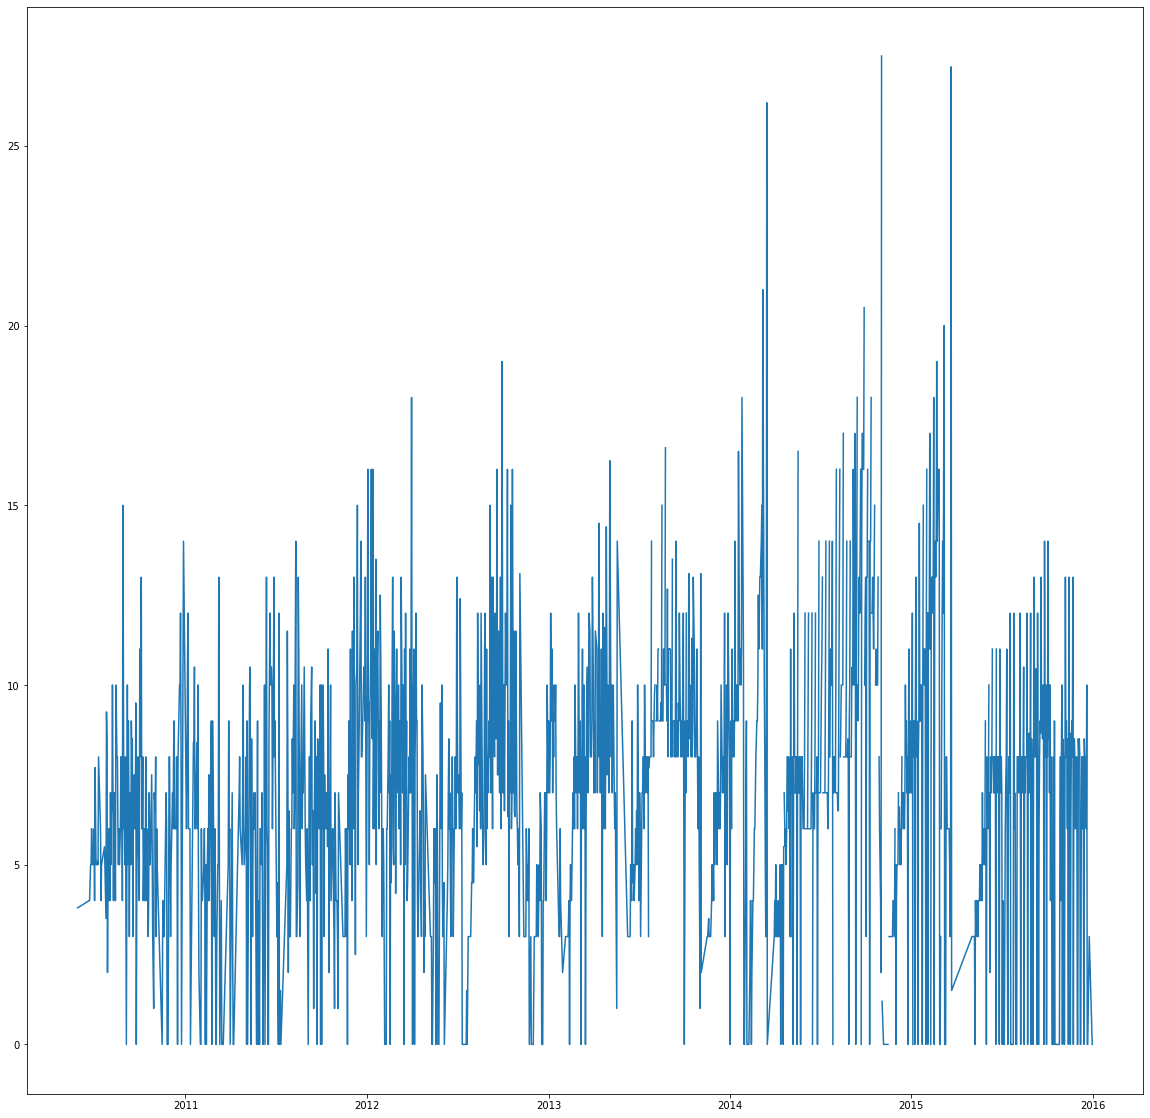

In [96]:
plt.plot(pre_garmin_edited.Date, pre_garmin_edited.Mileage)
plt.show()

# Garmin Data Wrangling

In [97]:
post_garmin = pd.read_csv("/content/drive/My Drive/runningdata.csv")
post_garmin.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Avg Vertical Ratio,Avg Vertical Oscillation,Training Stress Score®,Avg Power,Max Power,Grit,Flow,Total Strokes,Avg. Swolf,Avg Stroke Rate,Bottom Time,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp
0,Running,7/14/2020 5:17,False,Zebulon Running,10.02,"1,272",1:16:55,--,172,180,7:41,5:25,196,209,1.22,0,0,0,--,--,0,0,--,--,--,0:00,0,0:00,No,00:07.0,11,0
1,Running,7/13/2020 6:56,False,Zebulon Running,10.35,"1,307",1:16:12,--,173,184,7:22,5:10,163,172,1.27,0,0,0,--,--,0,0,--,--,--,0:00,0,0:00,No,00:37.5,12,0
2,Indoor Cycling,7/13/2020 5:35,False,Indoor Cycling,0,--,1:02:04,--,--,--,--,--,--,--,0.00,0,0,0,--,--,0,0,--,--,--,0:00,0,0:00,No,02:04.3,1,0
3,Indoor Cycling,7/12/2020 5:56,False,Indoor Cycling,0,--,1:07:01,--,--,--,--,--,--,--,0.00,0,0,0,--,--,0,0,--,--,--,0:00,0,0:00,No,07:01.2,1,0
4,Running,7/12/2020 5:16,False,Zebulon Running,1.01,124,08:40.4,--,168,174,8:34,7:27,46,--,1.12,0,0,0,--,--,0,0,--,--,--,0:00,0,0:00,No,00:05.7,2,0


In [98]:
post_garmin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594 entries, 0 to 3593
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Type             3594 non-null   object 
 1   Date                      3594 non-null   object 
 2   Favorite                  3594 non-null   bool   
 3   Title                     3594 non-null   object 
 4   Distance                  3594 non-null   object 
 5   Calories                  3594 non-null   object 
 6   Time                      3594 non-null   object 
 7   Max HR                    3594 non-null   object 
 8   Avg Run Cadence           3594 non-null   object 
 9   Max Run Cadence           3594 non-null   object 
 10  Avg Pace                  3594 non-null   object 
 11  Best Pace                 3594 non-null   object 
 12  Elev Gain                 3594 non-null   object 
 13  Elev Loss                 3594 non-null   object 
 14  Avg Stri

In [99]:
post_garmin2 = post_garmin.replace('--',np.nan)
post_garmin2.describe()

,Avg Stride Length,Avg Vertical Ratio,Avg Vertical Oscillation,Training Stress Score®,Flow,Min Temp,Max Temp
count,3594.000000,3594.0,3594.0,3594.0,3594.0,3594.0,3594.0
mean,0.459071,0.0,0.0,0.0,0.0,0.0,0.0
std,1.674200,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.170000,0.0,0.0,0.0,0.0,0.0,0.0
max,94.070000,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
post_garmin2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594 entries, 0 to 3593
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Type             3594 non-null   object 
 1   Date                      3594 non-null   object 
 2   Favorite                  3594 non-null   bool   
 3   Title                     3594 non-null   object 
 4   Distance                  3594 non-null   object 
 5   Calories                  3586 non-null   object 
 6   Time                      3594 non-null   object 
 7   Max HR                    1 non-null      object 
 8   Avg Run Cadence           1304 non-null   object 
 9   Max Run Cadence           1305 non-null   object 
 10  Avg Pace                  3384 non-null   object 
 11  Best Pace                 3301 non-null   object 
 12  Elev Gain                 2993 non-null   object 
 13  Elev Loss                 2901 non-null   object 
 14  Avg Stri

In [101]:
post_garmin3 = post_garmin2.drop(['Favorite','Max HR', 'Max Power','Avg Vertical Ratio','Avg Vertical Oscillation',
                                  'Training Stress Score®','Grit','Flow','Bottom Time','Min Temp','Surface Interval',
                                  'Decompression','Max Temp'], axis=1)

In [102]:
def convert_to_float(df, col):
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].astype(float)

columns_to_convert = ['Distance', 'Calories','Elev Gain','Elev Loss','Avg Run Cadence','Max Run Cadence',
                      'Avg Power','Total Strokes','Avg. Swolf','Avg Stroke Rate','Number of Laps']
for col in columns_to_convert:
    convert_to_float(post_garmin3, col)


In [103]:
post_garmin3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594 entries, 0 to 3593
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Activity Type      3594 non-null   object 
 1   Date               3594 non-null   object 
 2   Title              3594 non-null   object 
 3   Distance           3594 non-null   float64
 4   Calories           3586 non-null   float64
 5   Time               3594 non-null   object 
 6   Avg Run Cadence    1304 non-null   float64
 7   Max Run Cadence    1305 non-null   float64
 8   Avg Pace           3384 non-null   object 
 9   Best Pace          3301 non-null   object 
 10  Elev Gain          2993 non-null   float64
 11  Elev Loss          2901 non-null   float64
 12  Avg Stride Length  3594 non-null   float64
 13  Avg Power          7 non-null      float64
 14  Total Strokes      11 non-null     float64
 15  Avg. Swolf         11 non-null     float64
 16  Avg Stroke Rate    11 no

In [104]:
post_garmin3['Activity Type'].unique()

array(['Running', 'Indoor Cycling', 'Gym & Fitness Equipment', 'Cycling',
       'Pool Swimming', 'Strength Training', 'Treadmill Running', 'Other',
       'Street Running'], dtype=object)

In [105]:
len(post_garmin3[post_garmin3['Activity Type'] == 'Treadmill Running'])

29

In [106]:
def convert_to_seconds(time):
    split_time = ''.join(str(time)).split(':')
    h = split_time[0]
    m = split_time[1]
    s = split_time[2]
    converted = (((int(h) * 60) + int(m)) * 60) + float(s)
    return converted

In [107]:
def from_seconds_to_time_object(seconds, days = False):
    if days is True:
        d = seconds / 86400
        days_deci, da = math.modf(d)
        day = int(da)
        print('Day: ', day)
        pre_hour = days_deci * 24
        deci, int_1 = math.modf(pre_hour)
    else:
        h = seconds / 3600
        deci, int_1 = math.modf(h)
    hour = int(int_1)
    pre_mins = deci * 60
    deci2, int_2 = math.modf(pre_mins)
    minutes = int(int_2)
    pre_sec = deci2 * 60 
    deci3, int_3 = math.modf(pre_sec)
    seconds = int(int_3)
    microsecond = int(deci3*1000000)
    new_time = datetime.time(hour = hour, minute = minutes, second = seconds, microsecond = microsecond)
    return new_time

In [108]:
def prep_time_converter(df, col, coloncount):
    problem_time = []
    for idx, t in enumerate(df[col]):
        colon_count = 0
        try:
            if math.isnan(t):
                continue
        except:
            name = df.iloc[idx].name
            for char in t:
                if char is ':':
                    colon_count += 1
            if colon_count is 1:
                df.loc[name, col] = '00:' + t 
                t = '00:' + t
                if '.' not in t:
                    df.loc[name, col] = t + '.0'
            elif colon_count is 0:
                df.loc[name, col] = '00:00:' + t 
                t = '00:00:' + t
                if '.' not in t:
                    df.loc[name, col] = t + '.0'
            elif colon_count > coloncount:
                print(df.iloc[idx])
            elif '.' not in t:
                splitt = t.split(':')
                hour_num = float(splitt[0])
                if hour_num < 24:
                    df.loc[name, col] = t + '.0'
                else:
                    problem_time.append(df.loc[name, col])
                    continue
            # print(name, df.loc[name,col])
            sec = convert_to_seconds(df.loc[name, col])
            new_time = from_seconds_to_time_object(sec)
            df.loc[name, col] = new_time
    # df[col] = pd.to_datetime(df[col],format=format).dt.time

In [109]:
post_garmin3.Date = pd.to_datetime(post_garmin3.Date)

In [110]:
post_garmin3['Activity Type'].unique()

array(['Running', 'Indoor Cycling', 'Gym & Fitness Equipment', 'Cycling',
       'Pool Swimming', 'Strength Training', 'Treadmill Running', 'Other',
       'Street Running'], dtype=object)

In [111]:
pre_garmin_edited3 = pd.read_csv("/content/drive/My Drive/edited_pre_garmin.csv",index_col=0)

In [112]:
pre_garmin_edited3.Date = pd.to_datetime(pre_garmin_edited3.Date)

In [113]:
post_garmin3 = post_garmin3.sort_values(by='Date')
post_garmin3 = post_garmin3.rename(columns= {'Date': 'Datetime'})
post_garmin3['Date'] = [d.date() for d in post_garmin3['Datetime']]
post_garmin3.Date = pd.to_datetime(post_garmin3.Date)
prep_time_converter(post_garmin3, 'Time', 2)
running_data = post_garmin3[post_garmin3['Activity Type'].str.contains('Running')]

In [114]:
running_data2 = running_data[['Activity Type','Datetime', 'Title', 'Distance', 'Time','Avg Pace', 'Calories', 
                             'Elev Gain','Elev Loss', 'Avg Stride Length', 'Best Lap Time', 'Best Pace',
                             'Avg Run Cadence', 'Max Run Cadence', 'Number of Laps', 'Date']]

In [115]:
prep_time_converter(running_data2, 'Avg Pace', 2)
prep_time_converter(running_data2, 'Best Pace', 2)
prep_time_converter(running_data2, 'Best Lap Time', 2)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [116]:
print(running_data2.loc[:, 'Date'])
pre_garmin_edited3.loc[:, 'Date']

3593   2013-12-30
3592   2013-12-31
3591   2014-01-02
3590   2014-01-03
3589   2014-01-04
          ...    
6      2020-07-10
5      2020-07-11
4      2020-07-12
1      2020-07-13
0      2020-07-14
Name: Date, Length: 2074, dtype: datetime64[ns]


0      2010-05-29
1      2010-06-21
2      2010-06-22
3      2010-06-23
4      2010-06-24
          ...    
1978   2015-12-20
1980   2015-12-21
1981   2015-12-22
1982   2015-12-25
1983   2015-12-31
Name: Date, Length: 1673, dtype: datetime64[ns]

In [249]:
running_merged = running_data2.merge(pre_garmin_edited3, how='outer',left_on='Date', right_on='Date')
running_merged = running_merged.sort_values(by='Date')

In [250]:
post_garmin_rm = running_merged.loc[running_merged.Date >= '2013-12-30']
intersection = post_garmin_rm[post_garmin_rm.Date <= '2015-12-31']
intersection

,Activity Type,Datetime,Title,Distance,Time_x,Avg Pace,Calories,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Best Pace,Avg Run Cadence,Max Run Cadence,Number of Laps,Date,Weekday,Mileage,Time_y,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,raw_note
0,Running,2013-12-30 07:17:00,Untitled,9.10,01:06:37.999999,00:07:18.999999,1130.0,520.0,513.0,0.0,00:00:00,00:04:15,NaN,NaN,NaN,2013-12-30,Monday,9.0,NaN,NaN,NaN,NaN,NaN,Monday _ 12/30/13 _ 9 miles _ 7:19 pace
1,Running,2013-12-31 08:20:00,Untitled,8.01,00:57:45.999999,00:07:13,998.0,365.0,372.0,0.0,00:00:00,00:00:53,NaN,NaN,NaN,2013-12-31,Tuesday,8.0,NaN,NaN,NaN,NaN,NaN,Tuesday _ 8 miles _ 7:19 pace
3114,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,Wednesday,0.0,NaN,NaN,NaN,NaN,NaN,Wednesday _ 1/1/14 _ sick _ none
2,Running,2014-01-02 08:06:00,Untitled,8.13,01:00:28,00:07:26,1009.0,508.0,530.0,0.0,00:00:00,00:04:57,NaN,NaN,NaN,2014-01-02,Thursday,8.0,NaN,NaN,NaN,NaN,NaN,Thursday _ 8 miles _ 7:26 pace
3,Running,2014-01-03 10:03:00,Untitled,8.71,01:01:28,00:07:03.999999,1085.0,479.0,483.0,0.0,00:00:00,00:01:19,NaN,NaN,NaN,2014-01-03,Friday,9.0,NaN,NaN,NaN,NaN,NaN,Friday _ 9 miles _ 7:03 pace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,Running,2015-12-20 05:49:00,Wilmington Running,10.21,01:38:28,00:09:39,1283.0,82.0,85.0,0.0,00:00:00,00:06:04.999999,NaN,NaN,NaN,2015-12-20,Sunday,10.0,NaN,NaN,NaN,NaN,NaN,Sunday - 10 miles
3233,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-21,Monday,0.0,NaN,NaN,NaN,NaN,NaN,Monday - 12/21/15 - off
3234,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-22,Tuesday,0.0,NaN,NaN,NaN,NaN,NaN,Tuesday - I've failed. Not going to be able to...
3235,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25,Friday,3.0,NaN,NaN,NaN,NaN,NaN,Thursday - 12/25/15 - 3 miles


In [251]:
perfect_match = []
match = []
nan_fixed = []
problem = []
for idx, m in enumerate(intersection.Mileage):
    diff = m - intersection.Distance.iloc[idx]
    if m == intersection.Distance.iloc[idx]:
        perfect_match.append(idx)
    elif (diff > -0.5) and (diff < 0.5):
        match.append(idx)
    elif math.isnan(intersection.Distance.iloc[idx]):
        intersection.Distance.iloc[idx] = m
        nan_fixed.append(idx)
    else:
        problem.append(idx)
print('perfect!!!', len(perfect_match), 'good', len(match), 'nan_fixed', len(nan_fixed), 'check', len(problem))
    

perfect!!! 27 good 374 nan_fixed 123 check 115


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [252]:
def multiplying_times(time, factor):
    as_seconds = convert_to_seconds(time)
    time_prod = as_seconds * factor
    new_time = from_seconds_to_time_object(time_prod)
    return new_time

In [253]:
def adding_times(time1, time2):
    as_seconds_1 = convert_to_seconds(time1)
    as_seconds_2 = convert_to_seconds(time2)
    time_sum = as_seconds_1 + as_seconds_2
    new_time = from_seconds_to_time_object(time_sum)
    return new_time

In [254]:
# there will need to be a for loop here that goes through all of the changes to distance
# and time based upon runs where my watch died and converts the time using the above multiplying 
# and adding functions to get the cumulative time

In [255]:
def add_a_mile(df, dist, index):
    df.loc[index,'Distance'] += dist
    to_be_added = multiplying_times(df.loc[index,'Avg Pace'], dist)
    df.loc[index,'Time_x'] = adding_times(df.loc[index,'Time_x'], to_be_added)
    df.loc[index, 'Calories'] += 129*dist

In [124]:
# ones that just don't make any sense
# 59 which is 4-2-2014

In [125]:
# order: [index, Distance, Time_x, Avg Pace, Calories, ]
all_manual_entry = [[intersection.iloc[301].name, 6.6, datetime.time(hour=0, minute=52, second=15), datetime.time(hour=0, minute=7, second=55), 129*6.6],
                    [intersection.iloc[606].name, 13, datetime.time(hour=2, minute=10, second=00), datetime.time(hour=0, minute=10, second=00), 129*13],
                    [intersection.iloc[618].name, 8, datetime.time(hour=1, minute=9, second=4), datetime.time(hour=0, minute=8, second=38), 129*13],
                    [995,14,datetime.time(hour=1, minute=45, second=0), datetime.time(hour=0, minute=7, second=30), 129*14]]

In [126]:
for changes in all_manual_entry:
    running_merged.loc[changes[0], 'Distance'] = changes[1]
    running_merged.loc[changes[0], 'Time_x'] = changes[2]
    running_merged.loc[changes[0], 'Avg Pace'] = changes[3]
    running_merged.loc[changes[0], 'Calories'] = changes[4]

In [127]:
# list with the [dist, index] the distance that needs to be added and the index location of where the change needs to take place
changes_to_dist_cal_time = [[18,24],[1,38],[1,39],[12.5-9.85,54],[14-11.94,60],[21-18.41,63],[1,73],[1.3,92],
                            [5-2.66,96],[7-5.13,122],[1,133],[1,139],[1,143],[1,147],[1,153],[1,157],[1,161],
                            [1,166],[1,167],[7-2.15,168],[1,169],[1,172],[1,175],[1,179],[1,185],[1,191],
                            [2,196],[17-11.27,202],[10.5-2.77,226],[1,232],[14-11.08,237],[2,244],[15,249],
                            [12.7-6.22,261],[4-2.84,272],[1,298],[7-1.67,300],[1,307],[9-.68,323],
                            [8-3.69,329],[14.5-.74,340],[9-1.33,345],[11-8.21,354],[11-2.69,362],[18-14.63,369],
                            [13-11.17,371],[14-10.25,376],[16-9.95,379],[1,388],[1,389],[1,394],[1.96,414],
                            [2.03,418],[8-6.7,445],[11-2.98,451],[8-4.96,456],[7-6.1,462],[4-2.02,473],
                            [6-3.02,489],[12-6.07,499],[8-2.9,505],[8-.84,511],[8.5-7.25,522],[13-10.42,527],
                            [8-6.66,538],[9-6.3,542],[14-5.73,555],[8-2.02,562],[8-5.07,583],[10-8.53,584],
                            [13-2.23,591],[8.5-1.33,596],[1,620],[6-4.9,623]]


In [128]:
for idx, cha in enumerate(changes_to_dist_cal_time):
    nam = intersection.iloc[cha[1]].name
    changes_to_dist_cal_time[idx][1] = nam

In [129]:
for change in changes_to_dist_cal_time:
    add_a_mile(running_merged,change[0],change[1])

In [130]:
# for p in problem:
#     print(p, intersection.Distance.iloc[p], intersection.Mileage.iloc[p])

In [131]:
#impute NaN's from merged columns for date, Distance, Time
#impute calories from mileage

In [132]:
running_merged2 = running_merged[running_merged.Date.notnull()]

In [133]:
def imputing_nans_fx(df, col, col2):
    for idx, row in enumerate(df[col]):
        try:
            if pd.isnull(df[col].iloc[idx]): #math.isnan(row) or 
                name = df.iloc[idx].name
                df.loc[name, col] = df.loc[name, col2]
        except:
            continue
imputing_nans_fx(running_merged2, 'Distance', 'Mileage')
imputing_nans_fx(running_merged2, 'Datetime', 'Date')
prep_time_converter(running_merged2, 'Time_y', 2)
imputing_nans_fx(running_merged2, 'Time_x', 'Time_y')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [134]:
def imputing_Cal_nans_fx(df, col, col2):
    for idx, row in enumerate(df[col]):
        try:
            if math.isnan(row):
                name = df.iloc[idx].name
                df.loc[name, col] = df.loc[name, col2] * 129
        except:
            continue
imputing_Cal_nans_fx(running_merged2, 'Calories', 'Distance')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [135]:
def imputing_pace_nans_fx(df, col, col2, col3):
    for idx, row in enumerate(df[col]):
        try:
            if pd.isnull(row):
                name = df.iloc[idx].name
                if pd.isnull(df.loc[name,col2]):
                    continue
                else:
                    t = convert_to_seconds(df.loc[name,col2])
                    pace_sec = t / df.loc[name, col3]
                    new_pace = from_seconds_to_time_object(pace_sec)
                    df.loc[name, col] = new_pace
        except:
            continue
imputing_pace_nans_fx(running_merged2, 'Avg Pace', 'Time_x', 'Distance')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [136]:
running_merged2['Activity Type'] = running_merged2['Activity Type'].fillna('Running')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
running_merged3 = running_merged2[running_merged2.Distance != 0]

In [138]:
#removing excess columns
running_merged3.loc[:, 'Avg Stride Length'] = running_merged3.loc[:, 'Avg Stride Length'].replace(0,np.nan)
running_merged4 = running_merged3[['Activity Type','Datetime', 'Distance', 'Title','Time_x','Avg Pace', 
                                   'Calories','Elev Gain', 'Elev Loss',
                                   'Avg Stride Length', 'Best Lap Time','Best Pace',
                                   'Avg Run Cadence','Max Run Cadence','Number of Laps',
                                   'raw_note']]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [139]:
# check for manual edits to runs and impute pace, time, calories - done
# create the workout log, Swimming, Biking Log
# function for imputing indoor biking miles / calories
# visualizations
# totals
# app Creation

In [140]:
def manual_edits_check_fx(df, dist_col, time_col, pace_col, cal_col):
    manual_edit = []
    for idx, row in enumerate(df[pace_col]):
        
        if pd.isnull(row):
            continue
        else:
            name = df.iloc[idx].name
            pace_sec = convert_to_seconds(df.loc[name, pace_col])
            # print(pace_sec)
            time_sec = convert_to_seconds(df.loc[name, time_col])
            expected_sec = df.loc[name, dist_col] * pace_sec
            diff = abs(time_sec - expected_sec)
            # print(diff, time_sec, expected_sec)
            if diff > 10:
                manual_edit.append(name)
    return manual_edit
me = manual_edits_check_fx(running_merged4, 'Distance', 'Time_x', 'Avg Pace', 'Calories')
# this was to check the pace and mileage and time to make sure they all match and make
# sense. All of them did make sense so there was no need to adjust any times. 

In [141]:
running_merged4 = running_merged4.rename(columns = {'Time_x': 'Time'})

In [260]:
running_log = running_merged4.drop(630)
running_log.to_csv("/content/drive/My Drive/edited_running_log.csv")

### Biking Log

In [143]:
post_garmin3['Activity Type'].unique()

array(['Running', 'Street Running', 'Cycling', 'Strength Training',
       'Pool Swimming', 'Treadmill Running', 'Indoor Cycling',
       'Gym & Fitness Equipment', 'Other'], dtype=object)

In [144]:
post_garmin_bike = post_garmin3[post_garmin3['Activity Type'].str.contains('Cycling')]
post_garmin_bike = post_garmin_bike.drop(['Total Strokes','Avg. Swolf','Avg Stroke Rate'],axis=1)
pre_garmin_bike = pre_garmin_edited3[pre_garmin_edited3.Bike_Mileage.notnull()]
pre_garmin_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 37 to 1983
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Weekday          124 non-null    object        
 1   Date             125 non-null    datetime64[ns]
 2   Mileage          180 non-null    float64       
 3   Time             1 non-null      object        
 4   Workout_type     5 non-null      object        
 5   Workout_mins     5 non-null      float64       
 6   Swimming_meters  1 non-null      float64       
 7   Bike_Mileage     180 non-null    float64       
 8   raw_note         180 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 14.1+ KB


In [145]:
def previous_row(loc, amount):
    pre = loc-amount
    try:
        pre_garmin_bike.loc[loc,'Date'] = pre_garmin_edited3.loc[pre,'Date']
    except:
        amount += 1
        previous_row(loc, amount)


In [146]:
no_date_index = list(pre_garmin_bike.index[pre_garmin_bike.Date.isnull()])
for i in no_date_index:
    # pre = i-amount
    # pre_garmin_bike.loc[i,'Date'] = pre_garmin_edited3.loc[pre,'Date']
    previous_row(i, 1)
print(pre_garmin_bike.loc[1013,'Date'])
pre_garmin_bike.loc[1098,'Date']


2013-07-21 00:00:00


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Timestamp('2013-10-05 00:00:00')

In [147]:
bike_merged = post_garmin_bike.merge(pre_garmin_bike, how='outer',left_on='Date', right_on='Date')
bike_merged = bike_merged.sort_values(by='Date')
bike_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 1303 to 1302
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Activity Type      1303 non-null   object        
 1   Datetime           1303 non-null   datetime64[ns]
 2   Title              1303 non-null   object        
 3   Distance           1303 non-null   float64       
 4   Calories           1297 non-null   float64       
 5   Time_x             1303 non-null   object        
 6   Avg Run Cadence    3 non-null      float64       
 7   Max Run Cadence    3 non-null      float64       
 8   Avg Pace           1301 non-null   object        
 9   Best Pace          1258 non-null   object        
 10  Elev Gain          1195 non-null   float64       
 11  Elev Loss          1095 non-null   float64       
 12  Avg Stride Length  1303 non-null   float64       
 13  Avg Power          7 non-null      float64       
 14  Best 

In [148]:
for idx, d in enumerate(bike_merged.Distance):
    if pd.isnull(d):
        name = bike_merged.iloc[idx].name
        bike_merged.loc[name, 'Distance'] = bike_merged.loc[name, 'Bike_Mileage']
        bike_merged.loc[name, 'Datetime'] = bike_merged.loc[name, 'Date']
        bike_merged.loc[name, 'Activity Type'] = 'Cycling'


In [149]:
bike_merged2 = bike_merged[['Activity Type','Datetime','Title','Distance','Calories','Time_x',
                           'Avg Pace','Best Pace','Elev Gain','Elev Loss','Avg Power',
                           'Best Lap Time','Number of Laps','raw_note']]
bike_merged2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 1303 to 1302
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Activity Type   1483 non-null   object        
 1   Datetime        1483 non-null   datetime64[ns]
 2   Title           1303 non-null   object        
 3   Distance        1483 non-null   float64       
 4   Calories        1297 non-null   float64       
 5   Time_x          1303 non-null   object        
 6   Avg Pace        1301 non-null   object        
 7   Best Pace       1258 non-null   object        
 8   Elev Gain       1195 non-null   float64       
 9   Elev Loss       1095 non-null   float64       
 10  Avg Power       7 non-null      float64       
 11  Best Lap Time   1303 non-null   object        
 12  Number of Laps  1149 non-null   float64       
 13  raw_note        180 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(7)
memory us

In [150]:
cal_calc = bike_merged2[bike_merged2.Calories.notnull()]
cal_per_mi = cal_calc.Calories.sum() / cal_calc.Distance.sum()

In [151]:
for idx, c in enumerate(bike_merged2.Calories):
    if pd.isnull(c):
        name = bike_merged2.iloc[idx].name
        cals = bike_merged2.loc[name, 'Distance'] * cal_per_mi
        bike_merged2.loc[name, 'Calories'] = cals

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [152]:
# impute Indoor Cycling mileage, assume 4:30 pace
def indoor_cycling_impute(df):
    df_filt = df[df['Activity Type'] == 'Indoor Cycling']
    for idx, d in enumerate(df_filt['Distance']):
        if d == 0.0:
            name = df_filt.iloc[idx].name
            if pd.notnull(df_filt.loc[name,'Time_x']):          
                df.loc[name, 'Distance'] = convert_to_seconds(df.loc[name, 'Time_x']) / 270
                df.loc[name, 'Avg Pace'] = 13.3
                df.loc[name, 'Calories'] = df.loc[name, 'Distance'] * cal_per_mi
indoor_cycling_impute(bike_merged2)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [153]:
bike_merged2 = bike_merged2.rename(columns = {'Time_x': 'Time'})

In [154]:
biking_log = bike_merged2.copy()
biking_log.to_csv("/content/drive/My Drive/biking_log.csv")

### Workout Log

In [155]:
post_garmin3['Activity Type'].unique()

array(['Running', 'Street Running', 'Cycling', 'Strength Training',
       'Pool Swimming', 'Treadmill Running', 'Indoor Cycling',
       'Gym & Fitness Equipment', 'Other'], dtype=object)

In [156]:
post_garmin_workout = post_garmin3[post_garmin3['Activity Type'].str.contains('Strength Training') | 
                                   post_garmin3['Activity Type'].str.contains('Gym & Fitness Equipment')]
post_garmin_workout = post_garmin_workout[['Activity Type','Datetime','Title', 
                                           'Calories','Time','Date']]
pre_garmin_workout = pre_garmin_edited3[pre_garmin_edited3['Workout_type'].notnull()]
pre_garmin_workout = pre_garmin_workout[['Date','Workout_type','Workout_mins','raw_note']]
pre_garmin_workout.Workout_mins.unique()

array([ 30.,  45.,  20., 120.,  60.])

In [157]:
time_replace_dict = {20: datetime.time(hour = 0, minute = 20, second = 0, microsecond = 0),
                     30: datetime.time(hour = 0, minute = 30, second = 0, microsecond = 0),
                     45: datetime.time(hour = 0, minute = 45, second = 0, microsecond = 0),
                     60: datetime.time(hour = 1, minute = 0, second = 0, microsecond = 0),
                     120: datetime.time(hour = 2, minute = 0, second = 0, microsecond = 0)}
for idx, row in enumerate(pre_garmin_workout['Workout_mins']):
    name = pre_garmin_workout.iloc[idx].name
    for key, value in time_replace_dict.items():
        if row == key:
            pre_garmin_workout.loc[name, 'Workout_mins'] = value

In [158]:
workout_merged = post_garmin_workout.merge(pre_garmin_workout, how='outer',left_on='Date', right_on='Date')
workout_merged = workout_merged.sort_values(by='Date')

In [159]:
cal_calc_wo = workout_merged[workout_merged.Calories.notnull()]
total = 0
for t in cal_calc_wo['Time']:
    tot = convert_to_seconds(t)
    total = total + tot
cal_per_sec = cal_calc_wo.Calories.sum() / total

In [160]:
for idx, row in enumerate(workout_merged['Activity Type']):
    name = workout_merged.iloc[idx].name
    if pd.isnull(row):
        workout_merged.loc[name, 'Activity Type'] = 'Strength Training'
        workout_merged.loc[name, 'Datetime'] = workout_merged.loc[name, 'Date']
        workout_merged.loc[name, 'Title'] = workout_merged.loc[name, 'Workout_type']
        workout_merged.loc[name, 'Time'] = workout_merged.loc[name, 'Workout_mins']
        workout_merged.loc[name, 'Calories'] = convert_to_seconds(workout_merged.loc[name, 'Time']) * cal_per_sec


In [161]:
workout_log = workout_merged[['Activity Type', 'Datetime', 'Title', 'Calories', 
                              'Time', 'raw_note']]

In [162]:
workout_log.to_csv("/content/drive/My Drive/workout_log.csv")

### Swimming Log

In [163]:
post_garmin_swimming = post_garmin3[post_garmin3['Activity Type'] == 'Pool Swimming']
post_garmin_swimming = post_garmin_swimming.drop(['Avg Run Cadence','Max Run Cadence',
                                                  'Elev Gain','Elev Loss','Avg Power',
                                                  'Avg Stride Length'], 
                                                 axis = 1)
pre_garmin_swimming = pre_garmin_edited3[pre_garmin_edited3['Swimming_meters'].notnull()]
pre_garmin_swimming = pre_garmin_swimming[['Date','Swimming_meters','raw_note']]


In [164]:
swimming_merged = post_garmin_swimming.merge(pre_garmin_swimming, how='outer',left_on='Date', right_on='Date')
swimming_merged = swimming_merged.sort_values(by='Date')

In [165]:
cal_calc_swim = swimming_merged[swimming_merged.Calories.notnull()]
cal_per_m = cal_calc_swim.Calories.sum() / cal_calc_swim.Distance.sum()

In [166]:
for idx, row in enumerate(swimming_merged['Activity Type']):
    name = swimming_merged.iloc[idx].name
    if pd.isnull(row):
        swimming_merged.loc[name, 'Activity Type'] = 'Pool Swimming'
        swimming_merged.loc[name, 'Datetime'] = swimming_merged.loc[name, 'Date']
        swimming_merged.loc[name, 'Distance'] = swimming_merged.loc[name, 'Swimming_meters']
        swimming_merged.loc[name, 'Calories'] = swimming_merged.loc[name, 'Distance'] * cal_per_m

In [167]:
swimming_log = swimming_merged.drop(['Date','Swimming_meters'],axis=1)

In [168]:
swimming_log.to_csv("/content/drive/My Drive/swimming_log.csv")

# Totals

In [169]:
logs_list = [running_log, biking_log, workout_log, swimming_log]
pre_activity_log = pd.merge(running_log, biking_log, how='outer',on=['Activity Type',
                            'Datetime','Distance','Title','Time', 'Avg Pace',
                            'Best Pace', 'Calories','Elev Gain','Elev Loss',
                            'Best Lap Time','Number of Laps','raw_note'])
pre_activity_log2 = pd.merge(pre_activity_log, workout_log, how='outer',
                             on = ['Activity Type','Datetime','Title','Calories',
                                   'raw_note','Time'])
activity_log = pd.merge(pre_activity_log2, swimming_log, how='outer',
                        on=['Activity Type','Datetime','Title','Calories',
                            'Avg Pace','Best Pace','Number of Laps','raw_note',
                            'Best Lap Time','Time'])
activity_log = activity_log.sort_values('Datetime')
activity_log = activity_log.rename(columns={'Distance_y': 'Distance(m)', 'Distance_x': 'Distance(mi)'})
activity_log_cols = list(activity_log.columns)
activity_log2 = activity_log[['Activity Type', 'Title','Datetime','Distance(mi)',
                              'Distance(m)','Time','Avg Pace','Calories','Elev Gain',
                              'Elev Loss','Avg Stride Length','Best Lap Time',
                              'Best Pace', 'Avg Run Cadence', 'Max Run Cadence',
                              'Number of Laps','Avg Power','Total Strokes','Avg. Swolf',
                              'Avg Stroke Rate','raw_note']]

In [170]:
def time_totaling_fx(df, time_col,days=False):
    total = 0
    for t in df[time_col]:
        try:
            if math.isnan(t):
                continue
        except:
            sec = convert_to_seconds(t)
            total = sec + total
    new_time = from_seconds_to_time_object(total, days=days)
    return(total, new_time)

### Activity Totals

In [171]:
total_mileage = activity_log2['Distance(mi)'].sum()
total_calories = activity_log2['Calories'].sum()
total_elev_gain = activity_log2['Elev Gain'].sum()
total_elev_loss = activity_log2['Elev Loss'].sum()
print('Total Mileage Overall: ', total_mileage)
print('Total Calories Overall: ', total_calories)
print('Total Elevation Gain Overall: ', total_elev_gain)
print('Total Elevation Loss Overall: ', total_elev_loss)
tot_sec, activity_t_total = time_totaling_fx(activity_log2, 'Time',days=True)
print('Total Active Time: ', activity_t_total)

Total Mileage Overall:  37460.41018518519
Total Calories Overall:  3528004.4674767293
Total Elevation Gain Overall:  574573.0
Total Elevation Loss Overall:  572037.0
Day:  124
Total Active Time:  04:08:33.698117


### Running Totals

In [172]:
running_total = running_log.Distance.sum()
running_cal_total = running_log.Calories.sum()
running_el_gain = running_log['Elev Gain'].sum()
running_el_loss = running_log['Elev Loss'].sum()
running_max_cadence = running_log['Max Run Cadence'].max()
# running_av_str_length = running_log['Avg Stride Length'].mean()
# running_av_run_cadence = running_log['Avg Run Cadence'].mean()
print('Running Total Mileage: ', running_total)
tot_sec_running, running_t_total = time_totaling_fx(running_log, 'Time',days=True)
print('Running Total Time: ', running_t_total)
av_sec_pace = tot_sec_running / running_total
running_av_pace = from_seconds_to_time_object(av_sec_pace)
print('Running Average Pace: ', running_av_pace)
print('Running Total Calories: ', running_cal_total)
print('Running Elevation Gain Total: ', running_el_gain)
print('Running Elevation Loss Total: ', running_el_loss)
# - I can't do these two because an average of Averages isn't the correct answer
# print('Running Average Stride Length: ', running_av_str_length)
# print('Running Average Run Cadence: ', running_av_run_cadence)
print('Running Max Run Cadence: ', running_max_cadence)

Running Total Mileage:  19868.39
Day:  73
Running Total Time:  15:31:30.398787
Running Average Pace:  00:05:20.262004
Running Total Calories:  2498733.42
Running Elevation Gain Total:  291770.0
Running Elevation Loss Total:  293199.0
Running Max Run Cadence:  352.0


### Biking Totals

In [173]:
biking_total = biking_log.Distance.sum()
biking_cal_total = biking_log.Calories.sum()
biking_el_gain = biking_log['Elev Gain'].sum()
biking_el_loss = biking_log['Elev Loss'].sum()
print('Biking Total Mileage: ', biking_total)
tot_sec_bike, biking_t_total = time_totaling_fx(biking_log, 'Time',days=True)
print('Biking Total Time: ', biking_t_total)
print('Biking Total Calories: ', biking_cal_total)
biking_av_pace = from_seconds_to_time_object(tot_sec_bike / biking_total)
print('Biking Average Pace (min/mi): ', biking_av_pace)
print('Biking Elevation Gain: ', biking_el_gain)
print('Biking Elevation Loss: ', biking_el_loss)

Biking Total Mileage:  17592.020185185185
Day:  42
Biking Total Time:  16:36:49.599361
Biking Total Calories:  946222.547046867
Biking Average Pace (min/mi):  00:03:29.675157
Biking Elevation Gain:  282803.0
Biking Elevation Loss:  278838.0


### Swimming Totals

In [174]:
swimming_total = swimming_log.Distance.sum()
swimming_cal_total = swimming_log.Calories.sum()
swimming_tot_strokes = swimming_log['Total Strokes'].sum()
print('Swimming Total Distance: ', swimming_total)
tot_sec_swim, swimming_t_total = time_totaling_fx(swimming_log, 'Time',days=True)
print('Swimming Total Time: ', swimming_t_total)
print('Swimming Total Calories: ', swimming_cal_total)
print('Swimming Total Strokes: ', swimming_tot_strokes)

Swimming Total Distance:  83653.0
Day:  0
Swimming Total Time:  04:50:47.699995
Swimming Total Calories:  13099.559874185577
Swimming Total Strokes:  5642.0


### Workout Totals

In [175]:
workout_cal_total = workout_log.Calories.sum()
tot_sec_wo, workout_t_total = time_totaling_fx(workout_log, 'Time',days=True)
print('Workout Total Time: ', workout_t_total)
print('Workout Total Calories: ', workout_cal_total)

Day:  7
Workout Total Time:  15:09:25.999972
Workout Total Calories:  69948.94055567666


# Streaks

I will be looking for the longest consecutive streaks that I have on each activity

- possibly what would be really cool is if I can search for patterns and the longest streak of those patterns as well

- this could also be useful to find injury data as well

## Running

In [181]:
running_log[running_log.Datetime > '2017-09-29']

,Activity Type,Datetime,Distance,Title,Time,Avg Pace,Calories,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Best Pace,Avg Run Cadence,Max Run Cadence,Number of Laps,raw_note
878,Running,2017-09-29 05:48:00,7.22,Lubbock Running,00:53:08.999999,00:07:20.999999,884.0,29.0,28.0,1.25,00:00:00,00:05:51,175.0,194.0,NaN,NaN
879,Running,2017-09-30 05:42:00,3.17,Lubbock Running,00:24:22.999999,00:07:41,387.0,22.0,14.0,1.21,00:00:00,00:07:13,173.0,182.0,NaN,NaN
880,Running,2017-10-01 05:40:00,15.25,Lubbock Running,01:53:45.999999,00:07:28,1865.0,84.0,77.0,1.22,00:00:00,00:06:44,176.0,191.0,NaN,NaN
881,Running,2017-10-02 05:42:00,3.22,Lubbock Running,00:25:04,00:07:46,388.0,29.0,26.0,1.20,00:00:00,00:06:37,173.0,184.0,NaN,NaN
882,Running,2017-10-03 05:41:00,8.13,Lubbock Running,01:00:26,00:07:26,984.0,44.0,32.0,1.23,00:00:00,00:05:39.999999,176.0,191.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,Running,2020-07-10 05:30:00,9.40,Zebulon Running,01:10:40,00:07:30.999999,1191.0,203.0,213.0,1.24,00:02:50.800000,00:05:37.999999,172.0,178.0,10.0,NaN
2070,Running,2020-07-11 05:30:00,11.16,Zebulon Running,01:24:14,00:07:32.999999,1415.0,164.0,173.0,1.24,00:01:11.400000,00:05:11,172.0,178.0,12.0,NaN
2071,Running,2020-07-12 05:16:00,1.01,Zebulon Running,00:08:40.399999,00:08:33.999999,124.0,46.0,NaN,1.12,00:00:05.700000,00:07:26.999999,168.0,174.0,2.0,NaN
2072,Running,2020-07-13 06:56:00,10.35,Zebulon Running,01:16:12,00:07:21.999999,1307.0,163.0,172.0,1.27,00:00:37.500000,00:05:10,173.0,184.0,12.0,NaN


In [182]:
running_log.tail()

,Activity Type,Datetime,Distance,Title,Time,Avg Pace,Calories,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Best Pace,Avg Run Cadence,Max Run Cadence,Number of Laps,raw_note
2069,Running,2020-07-10 05:30:00,9.40,Zebulon Running,01:10:40,00:07:30.999999,1191.0,203.0,213.0,1.24,00:02:50.800000,00:05:37.999999,172.0,178.0,10.0,NaN
2070,Running,2020-07-11 05:30:00,11.16,Zebulon Running,01:24:14,00:07:32.999999,1415.0,164.0,173.0,1.24,00:01:11.400000,00:05:11,172.0,178.0,12.0,NaN
2071,Running,2020-07-12 05:16:00,1.01,Zebulon Running,00:08:40.399999,00:08:33.999999,124.0,46.0,NaN,1.12,00:00:05.700000,00:07:26.999999,168.0,174.0,2.0,NaN
2072,Running,2020-07-13 06:56:00,10.35,Zebulon Running,01:16:12,00:07:21.999999,1307.0,163.0,172.0,1.27,00:00:37.500000,00:05:10,173.0,184.0,12.0,NaN
2073,Running,2020-07-14 05:17:00,10.02,Zebulon Running,01:16:55,00:07:41,1272.0,196.0,209.0,1.22,00:00:07,00:05:25,172.0,180.0,11.0,NaN


In [287]:
def streak_finder_fx(df, col):
    streak = 0
    streak_count = []
    gap_length = []
    check = []
    largest_streak = 0
    for idx, date in enumerate(df[col]):
        if idx > 0:
            diff = date - df[col].iloc[idx-1]
            if diff.days >= 2 and diff.total_seconds() >= 172800:
                gap_length.append(diff.days)
                streak_count.append(streak)
                if streak > largest_streak:
                    largest_streak = streak
                    larg_streak_end = date
                    larg_streak_begin = df[col].iloc[idx - streak]
                streak = 0
            elif diff.days < 2 and diff.total_seconds() > 129600:
                check.append(idx)
            elif idx == (len(df[col])-1):
                if streak > largest_streak:
                    largest_streak = streak
                    larg_streak_end = date
                    larg_streak_begin = df[col].iloc[idx - streak]
            elif diff.days == 1:
                streak += 1
    larg_streak_info = [largest_streak, larg_streak_begin, larg_streak_end]
    return (larg_streak_info, streak_count, gap_length, check)    


In [195]:
cols = list(running_log.columns)
cols

['Activity Type',
 'Datetime',
 'Distance',
 'Title',
 'Time',
 'Avg Pace',
 'Calories',
 'Elev Gain',
 'Elev Loss',
 'Avg Stride Length',
 'Best Lap Time',
 'Best Pace',
 'Avg Run Cadence',
 'Max Run Cadence',
 'Number of Laps',
 'raw_note']

In [259]:
129*6

774

In [243]:
str(datetime.datetime(2018,1,14,5,42,0))

'2018-01-14 05:42:00'

In [270]:
manual_activities = {
    'Activity Type': ['Running','Running','Running','Running','Running','Running'], 
    'Datetime': [datetime.datetime(2019,11,2,5,41,0),datetime.datetime(2019,11,28,7,43,0),
    datetime.datetime(2018,1,15,5,42,0),datetime.datetime(2018,1,16,5,42,0),
    datetime.datetime(2018,1,17,5,42,0),datetime.datetime(2018,1,18,5,42,0)],
    'Distance': [1.78,8.05, 3,8,6,6],
    'Title': ['Raleigh Running','Raleigh Running', 'Cruise running','Cruise running',
              'Cruise running','Cruise running'],
    'Time': [datetime.time(hour = 0, minute = 14, second = 16, microsecond = 0),
             datetime.time(hour = 1, minute = 2, second = 29, microsecond = 0),
             datetime.time(hour = 0, minute = 22, second = 30, microsecond = 0),
             datetime.time(hour = 1, minute = 0, second = 0, microsecond = 0),
             datetime.time(hour = 0, minute = 45, second = 0, microsecond = 0),
             datetime.time(hour = 0, minute = 45, second = 0, microsecond = 0)],
    'Avg Pace': [datetime.time(hour = 0, minute = 7, second = 59, microsecond = 0),
                 datetime.time(hour = 0, minute = 7, second = 45, microsecond = 0),
                 datetime.time(hour = 0, minute = 7, second = 30, microsecond = 0),
                 datetime.time(hour = 0, minute = 7, second = 30, microsecond = 0),
                 datetime.time(hour = 0, minute = 7, second = 30, microsecond = 0),
                 datetime.time(hour = 0, minute = 7, second = 30, microsecond = 0)],
    'Calories': [263,1182,1806,1032,774,774],
    'Elev Gain': [64,132,np.nan,np.nan,np.nan,np.nan],
    'Elev Loss': [64,142,np.nan,np.nan,np.nan,np.nan],
    'Avg Stride Length': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
    'Best Lap Time': [datetime.time(hour = 0, minute = 7, second = 21, microsecond = 0),
                      datetime.time(hour = 0, minute = 7, second = 24, microsecond = 0),
                      np.nan,np.nan,np.nan,np.nan],
    'Best Pace': [datetime.time(hour = 0, minute = 0, second = 0, microsecond = 0),
                  datetime.time(hour = 0, minute = 7, second = 24, microsecond = 0),
                  np.nan,np.nan,np.nan,np.nan],
    'Avg Run Cadence': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
    'Max Run Cadence': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],    
    'Number of Laps': [2,8,3,8,6,6],
    'raw_note': [np.nan,np.nan,'on a cruise!','on a cruise!','on a cruise!','on a cruise!']
}

In [272]:
man_act = pd.DataFrame.from_dict(manual_activities)

In [273]:
running_log = running_log.append(man_act,ignore_index=True)

In [274]:
running_log

,Activity Type,Datetime,Distance,Title,Time,Avg Pace,Calories,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Best Pace,Avg Run Cadence,Max Run Cadence,Number of Laps,raw_note
0,Running,2010-05-29 00:00:00,3.80,NaN,00:27:18.999999,00:07:11.315789,490.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday 5/29/10 4 miles 27:19 it was a little...
1,Running,2010-06-21 00:00:00,4.00,NaN,NaN,NaN,516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday 6/21/10_ 4 miles
2,Running,2010-06-22 00:00:00,4.00,NaN,NaN,NaN,516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...
3,Running,2010-06-23 00:00:00,4.50,NaN,NaN,NaN,580.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday 6/23/10_ 4.5 miles_35 minutes
4,Running,2010-06-24 00:00:00,5.00,NaN,NaN,NaN,645.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday 6/25/10_ 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,Running,2019-11-28 07:43:00,8.05,Raleigh Running,01:02:29,00:07:45,1182.0,132.0,142.0,NaN,00:07:24,00:07:24,NaN,NaN,8.0,NaN
3020,Running,2018-01-15 05:42:00,3.00,Cruise running,00:22:30,00:07:30,1806.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,on a cruise!
3021,Running,2018-01-16 05:42:00,8.00,Cruise running,01:00:00,00:07:30,1032.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,on a cruise!
3022,Running,2018-01-17 05:42:00,6.00,Cruise running,00:45:00,00:07:30,774.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,on a cruise!


In [ ]:
# 1820 - beginning
# 1950 -endish

In [286]:
running_log.loc[1800:1824]

,Activity Type,Datetime,Distance,Title,Time,Avg Pace,Calories,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Best Pace,Avg Run Cadence,Max Run Cadence,Number of Laps,raw_note
1800,Running,2017-09-07 05:41:00,8.61,Lubbock Running,01:06:09,00:07:41,992.0,42.0,39.0,1.22,00:00:00,00:06:08,171.0,182.0,NaN,NaN
1801,Running,2017-09-07 09:00:00,3.00,Late to class,00:24:00,00:08:00,387.0,NaN,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN
1802,Running,2017-09-08 05:36:00,6.74,Lubbock Running,00:53:42.999999,00:07:58,813.0,29.0,23.0,1.17,00:00:00,00:07:15.999999,172.0,180.0,NaN,NaN
1803,Running,2017-09-09 05:53:00,3.24,Lubbock Running,00:25:11.999999,00:07:46.999999,396.0,34.0,32.0,1.20,00:00:00,00:07:18.999999,172.0,180.0,NaN,NaN
1804,Running,2017-09-11 05:37:00,3.18,Lubbock Running,00:24:53.999999,00:07:50,389.0,26.0,17.0,1.20,00:00:00,00:07:23,171.0,178.0,NaN,NaN
1805,Running,2017-09-12 05:37:00,7.48,Lubbock Running,00:56:28,00:07:32.999999,910.0,48.0,43.0,1.22,00:00:00,00:05:01.999999,174.0,196.0,NaN,NaN
1806,Running,2017-09-13 05:42:00,6.04,Lubbock Running,00:45:16.999999,00:07:30,737.0,22.0,20.0,1.22,00:00:00,00:06:00.999999,175.0,188.0,NaN,NaN
1807,Running,2017-09-14 05:45:00,8.17,Lubbock Running,00:59:35.999999,00:07:18,995.0,54.0,41.0,1.25,00:00:00,00:06:14,177.0,190.0,NaN,NaN
1808,Running,2017-09-15 05:39:00,7.06,Lubbock Running,00:54:26,00:07:43,859.0,25.0,23.0,1.20,00:00:00,00:07:01.999999,174.0,182.0,NaN,NaN
1809,Running,2017-09-16 05:46:00,3.24,Lubbock Running,00:25:27,00:07:52,392.0,20.0,21.0,1.18,00:00:00,00:07:00,173.0,182.0,NaN,NaN


In [283]:
# running_log[running_log.Datetime == '2018-01-28 06:59:00']
running_log.iloc[-1,1] - running_log.loc[1822,'Datetime']


Timedelta('1018 days 23:29:00')

In [244]:
running_log.loc[1939,'Datetime']

Timestamp('2018-01-14 05:42:00')

In [275]:
running_log= running_log.sort_values(by='Datetime')

In [ ]:
# need to check to make sure I am not missing any more days, I need to figure out how to know if an entire day has passed. and go back to the day that may be the problem. 

In [288]:
largest, streaks, gaps, check = streak_finder_fx(running_log, 'Datetime')
largest

[480, Timestamp('2019-05-28 04:34:00'), Timestamp('2020-07-14 05:17:00')]

In [277]:
streaks

[0,
 5,
 5,
 5,
 4,
 0,
 6,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 3,
 0,
 5,
 11,
 4,
 5,
 4,
 3,
 2,
 4,
 4,
 2,
 0,
 3,
 0,
 0,
 4,
 0,
 4,
 4,
 2,
 2,
 0,
 4,
 1,
 1,
 2,
 0,
 3,
 0,
 3,
 2,
 2,
 4,
 1,
 0,
 4,
 0,
 5,
 0,
 1,
 0,
 4,
 2,
 2,
 0,
 5,
 3,
 2,
 0,
 0,
 5,
 0,
 3,
 6,
 5,
 4,
 6,
 4,
 5,
 3,
 0,
 3,
 0,
 12,
 4,
 5,
 5,
 5,
 1,
 2,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 3,
 7,
 4,
 5,
 3,
 6,
 5,
 2,
 7,
 5,
 5,
 2,
 4,
 1,
 7,
 0,
 5,
 5,
 5,
 5,
 1,
 0,
 5,
 5,
 5,
 5,
 12,
 5,
 5,
 5,
 5,
 5,
 12,
 5,
 6,
 5,
 3,
 0,
 5,
 5,
 0,
 1,
 5,
 5,
 5,
 3,
 3,
 0,
 5,
 0,
 3,
 5,
 5,
 2,
 7,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 5,
 5,
 4,
 5,
 12,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 4,
 6,
 3,
 6,
 4,
 5,
 7,
 1,
 4,
 6,
 4,
 5,
 12,
 21,
 3,
 2,
 16,
 3,
 6,
 28,
 11,
 8,
 9,
 7,
 9,
 12,
 2,
 14,
 13,
 2,
 8,
 19,
 2,
 11,
 4,
 10,
 14,
 10,
 4,
 7,
 5,
 2,
 4,
 10,
 2,
 7,
 11,
 37,
 5,
 4,
 5,
 7,
 4,
 11,
 18,
 10,
 3,
 9,
 0,
 3,
 0,
 2,
 6,
 8,
 10,
 3,
 9,
 0,
 0,
 0,
 0,

In [ ]:
gaps

[23,
 2,
 2,
 2,
 6,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 11,
 3,
 5,
 3,
 3,
 2,
 3,
 5,
 4,
 2,
 3,
 7,
 3,
 5,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 4,
 14,
 4,
 13,
 4,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 3,
 2,
 2,
 4,
 2,
 3,
 13,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 9,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 10,
 4,
 3,
 4,
 2,
 7,
 2,
 2,
 2,
 2,
 10,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 4,
 7,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 5,
 4,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 21,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 12,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 7,
 2,
 2,
 2,
 14,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 14,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 41,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 157,
 3,
 2,
 2,
 3,
 2,
 2

## Biking

In [ ]:
155+812+24+72

1063

## 

## Visualizations

In [ ]:
activity_log2 = activity_log2.set_index('Datetime')

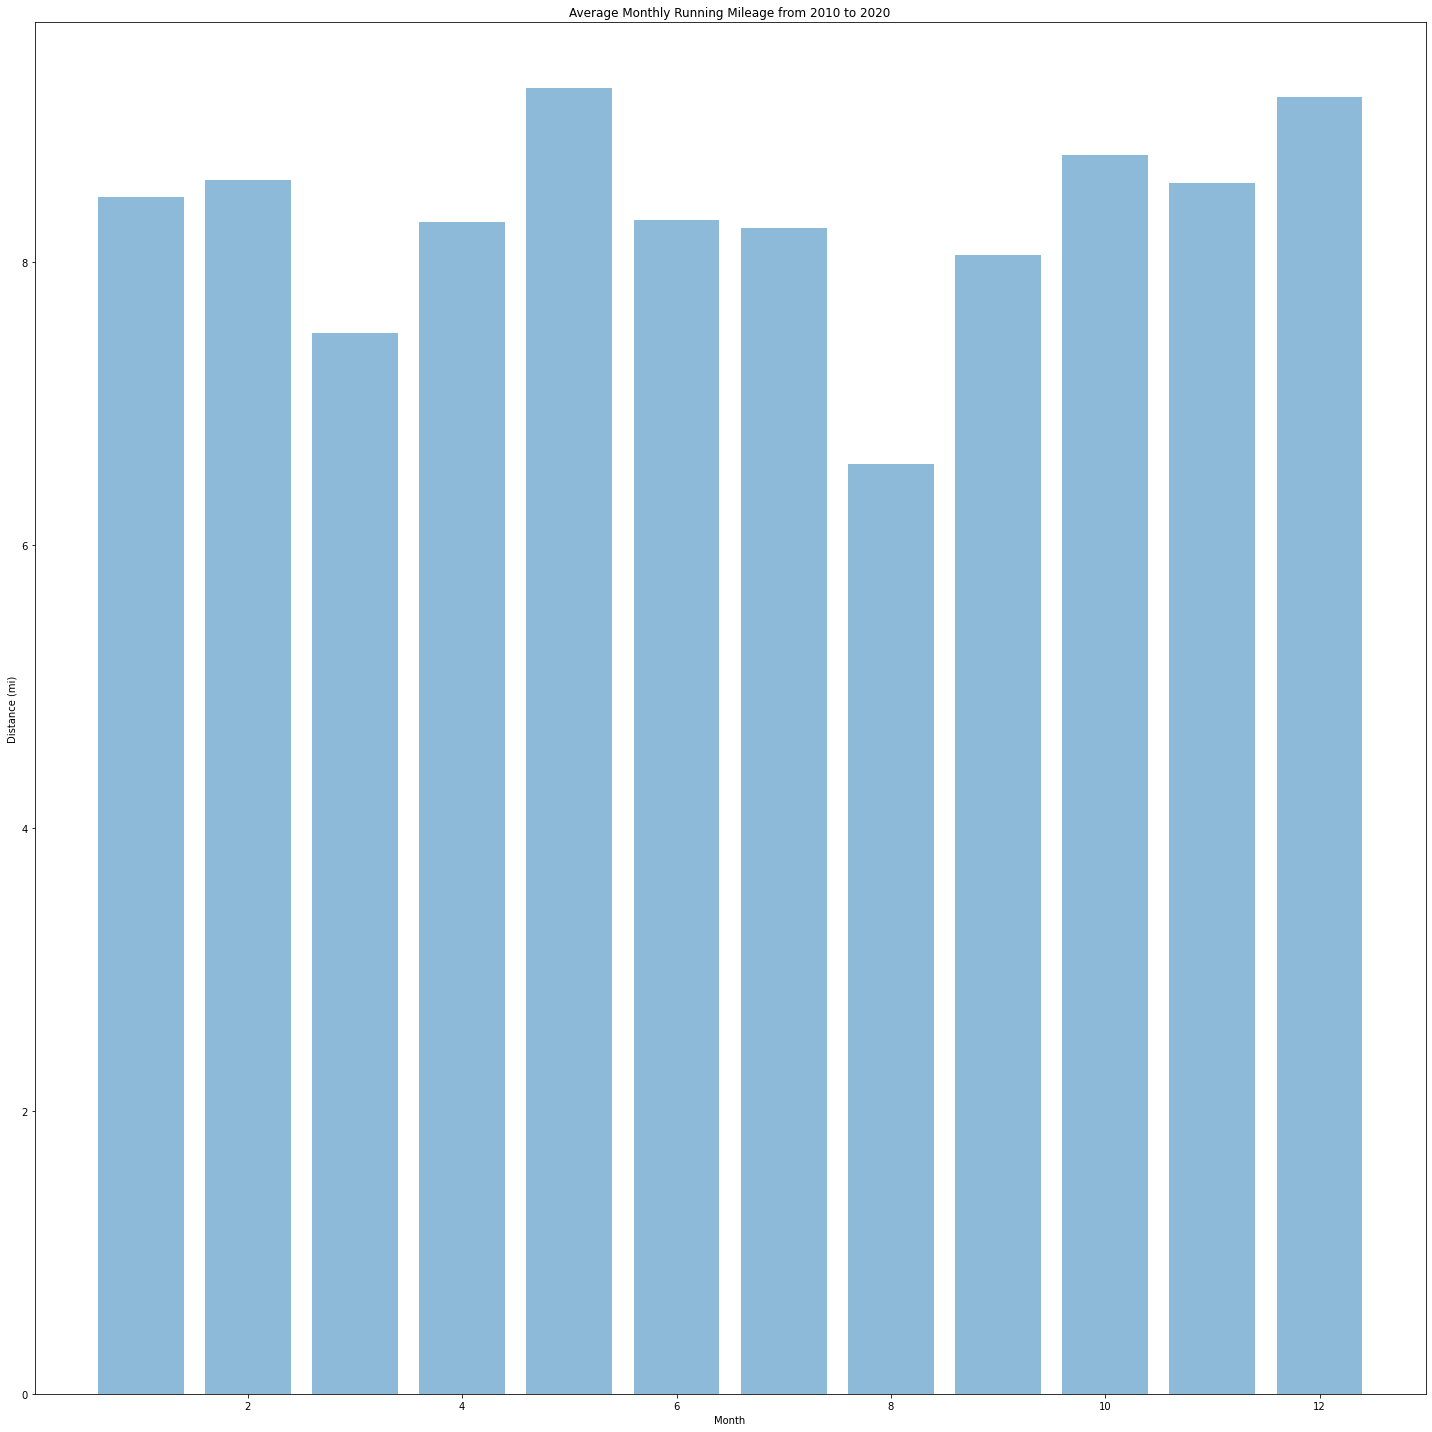

In [ ]:
monthavg = []
monthsem = []
monthstd = []
for i in range(1,13):
    monthavg.append(np.mean(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
    monthsem.append(stats.sem(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
    monthstd.append(np.std(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
    
fig, ax = plt.subplots()
ax.bar(activity_log2.index.month.unique(), monthavg, yerr = monthsem, alpha=0.5, ecolor='black', capsize=10)
ax.set_title('Average Daily Running Mileage Monthly from 2010 to 2020')
ax.set_xlabel('Month')
ax.set_ylabel('Distance (mi)')
plt.tight_layout()
plt.show()

[3194.288, 2920.146, 2982.8599999999997, 2281.23, 3501.339, 3512.1859999999997, 2900.6361851851852, 3492.5310000000004, 3249.775, 3569.9640000000004, 2443.517, 3411.938]


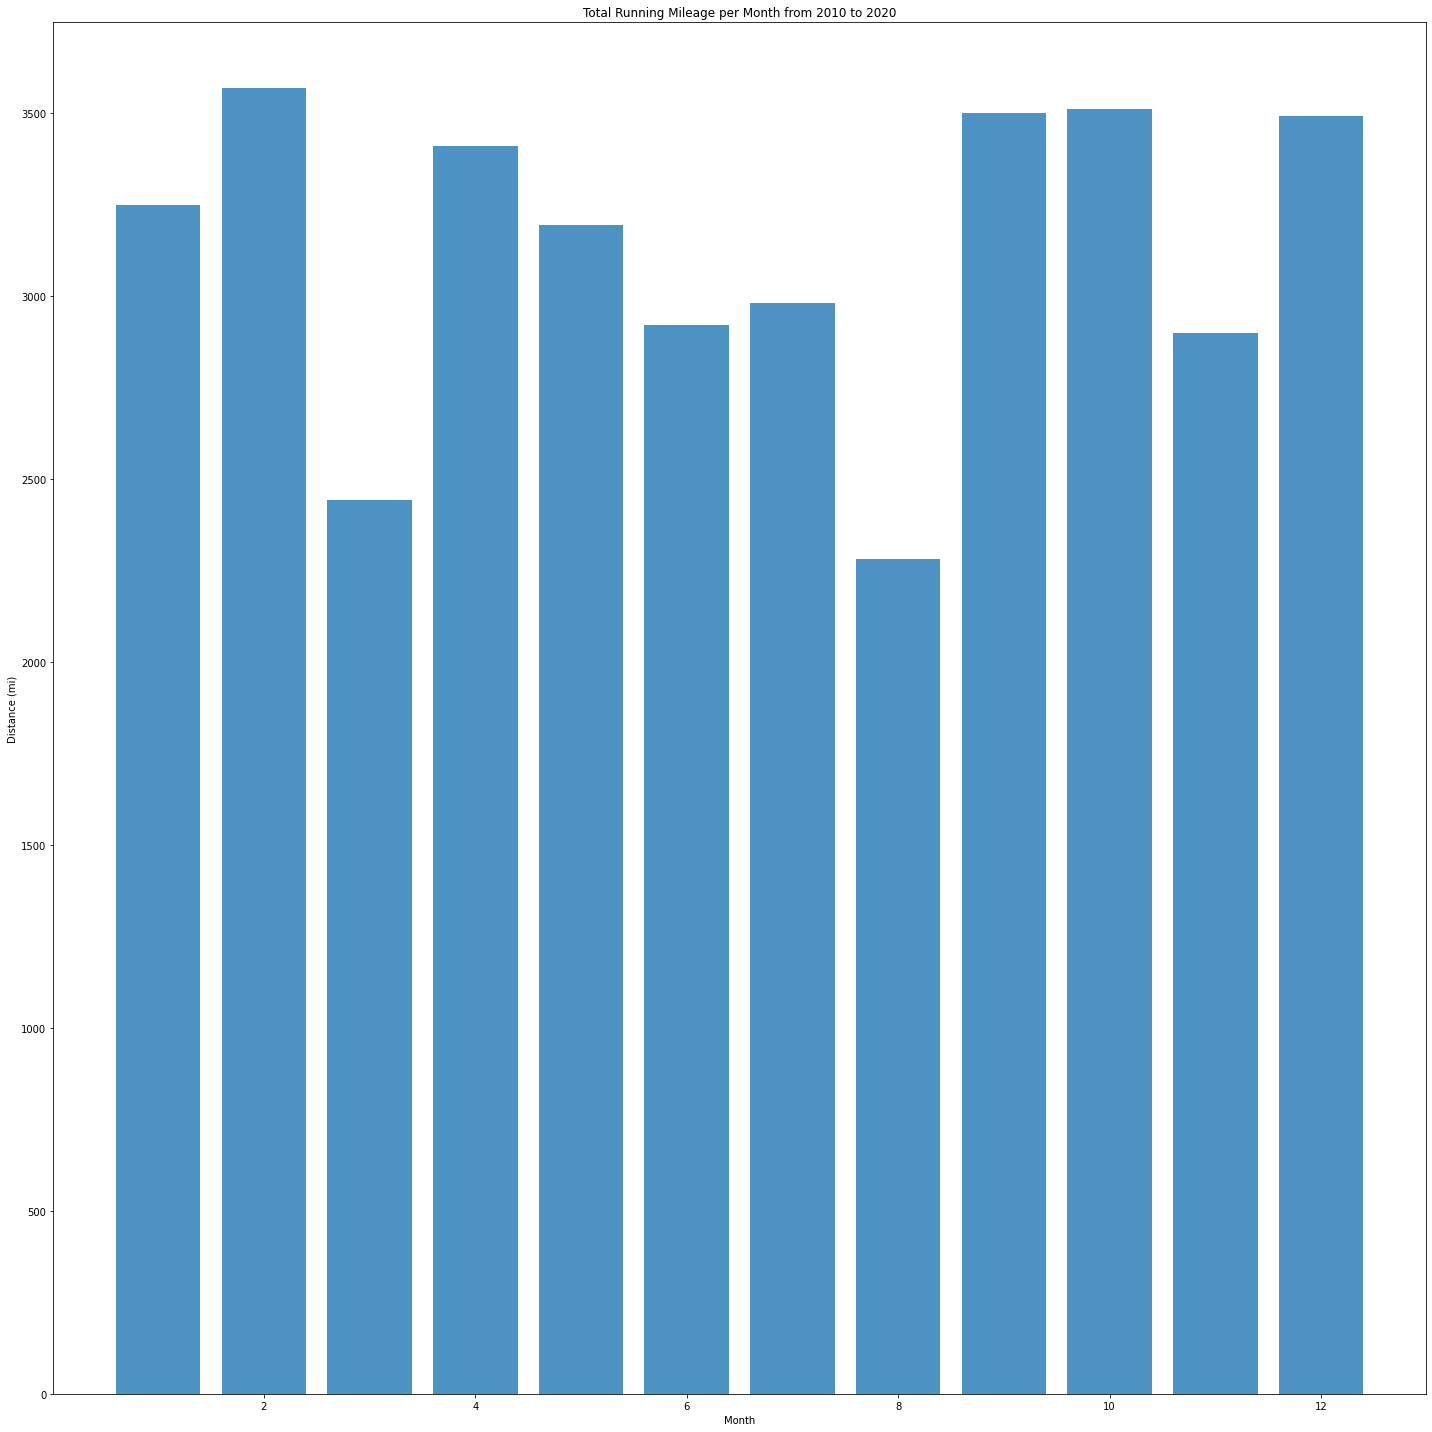

In [ ]:
monthavg = []
monthsem = []
monthstd = []
for i in range(1,13):
    monthavg.append(np.sum(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
    monthsem.append(stats.sem(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
    monthstd.append(np.std(activity_log2['Distance(mi)'][activity_log2.index.month == i]))
fig, ax = plt.subplots()
ax.bar(activity_log2.index.month.unique(), monthavg, yerr = monthsem, alpha=0.8, ecolor='black', capsize=45)
ax.set_title('Total Running Mileage per Month from 2010 to 2020')
ax.set_xlabel('Month')
ax.set_ylabel('Distance (mi)')
plt.tight_layout()
plt.show()

In [ ]:
activity_yearavg = activity_log2.resample('Y').sum()

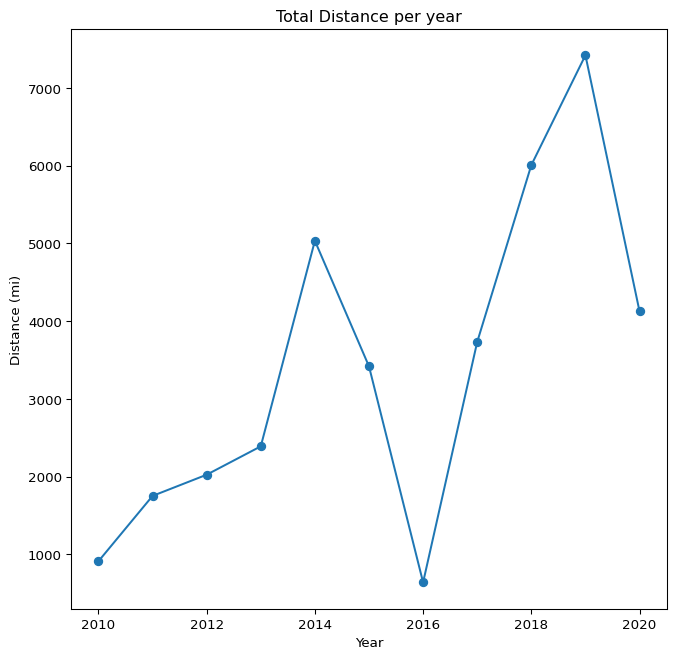

In [ ]:
def yearlyavgfigs(df, loc, **keyword_parameters):
    ''' this function takes in a dataframe and a location (column) and displays the average yearly rainfall 
    for each location. Only can take up to 2 locations
    '''
    plt.figure(figsize = (400/50, 400/50),dpi=96)
    if len(loc) == 1:
        if ('color' in keyword_parameters):
            plt.plot(df.index.year, df[loc[0]], keyword_parameters['color'], marker='o')
        else:
            plt.plot(df.index.year, df[loc[0]], marker='o')
        plt.title('Total Distance per year')
    else:
        plt.plot(df.index.year, df[loc[0]])
        plt.plot(df.index.year, df[loc[1]])
        plt.title("\n".join(wrap('Average Yearly Rainfall in ' + loc[0] + '-' + loc[1] + ' from 1980 to 2019', 
                                 60)))
    plt.xlabel('Year')
    plt.ylabel('Distance (mi)')
    plt.show()
yearlyavgfigs(activity_yearavg, ['Distance(mi)'])

In [ ]:
activity_month_avg = activity_log2.resample('M').sum()
plt.plot(activity_month_avg.index.month, activity_month_avg['Distance(mi)'],marker='o')
plt.title('Monthly Distance (mi)')
plt.xlabel('Month')
plt.ylabel('Distance (mi)')
plt.show()

# Future Garmin Data Web Scraping

In [ ]:
!pip install requests

In [ ]:
!pip install beautifulsoup4

In [ ]:
import numpy as np
import pandas as pd
import requests
import bs4
import lxml.etree as xml

In [ ]:
URL = "https://connect.garmin.com/modern/activities"

requests.get(URL)

<Response [200]>

In [ ]:
requests.get(URL, {}).text

In [ ]:
web_page = bs4.BeautifulSoup(requests.get(URL, {}).text, "lxml")

In [ ]:
web_page

In [ ]:
web_page.head.title

<title data-react-helmet="true">Garmin Connect | </title>

In [ ]:
web_page.body

<body><noscript id="gatsby-noscript">This app works best with JavaScript enabled.</noscript><div id="___gatsby"><div role="group" style="outline:none" tabindex="-1"><div><header class="c017"><h1 class="c0116 c0118"><a class="c018" href="/" title="Connect"></a></h1><div class="c0114"></div></header><main class="c014 c016"><div class="c013"><div class="c011"><div class="c012" id="gauth-widget"><noscript>To sign in to your Garmin account, please enable JavaScript in your web browser.</noscript></div></div><div id="loginGauth"></div></div></main><footer class="c0123"><div></div><div class="c0132"><span class="c0129 c0133"><a href="https://www.instagram.com/garminfitness/" title="Instagram"></a></span><span class="c0130 c0134"><a href="https://www.facebook.com/garminfit" title="Facebook"></a></span><span class="c0131 c0135"><a href="https://twitter.com/garminfitness" title="Twitter"></a></span></div><div id="consent"></div></footer></div></div></div><script id="gatsby-script-loader">/*<![CD

In [ ]:
sub_webpage = web_page.find_all(name="li") #, attrs={'class': 'list-item animated row-fluid'}

In [ ]:
sub_webpage

[]

I would like to make searchable notes that I could go through with links to exercises for injuries and such. It would be really useful to be able to have the types of injuries that I have gone through before and be able to just immediately have the stretches and such that worked. Then I can the next time find out how that went and then adjust based upon the previous injury timeline and see what works best for recovery for me. 